# 02_exploratory_data_analysis_realized_volatility_capstone_project

## Some questions to explore and answer 

1) Explore and understand the data for various stocks in the two key files: **book_train** and **trade_train**
        
* How do the 'wap' (weight average bid-ask price) and trade prices move during a time bucket ?
* Does 'wap' impact the 'trade price' or vice-versa ?
* Build some features from the data in the two files and see how these features are related to the 'realized_volatility'
* What is the distribution of realized volatility ? What about some other features like size, turnover ?

2) Understand how 'realized_volatility' moves with time. Is it auto-correlated? While we do not have data for sequential time buckets, we could create smaller **'time_segments'**, say 20-sec or 30-sec within the 10-minute time bucket and then calculate and visualize the 'realized_volatility' of these sequential time_segments.

3) Is realized_volatility of different stocks connected ? Are there any clusters of stocks with similar volatility across time buckets?



In [626]:
import pandas as pd
import numpy as np
import glob
from sb_utils import save_file

import seaborn as sns
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
from scipy.stats import norm
import pylab

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import kstest, norm

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


In [1]:
#pip install fastparquet

In [2]:
#pip install pyarrow

## 1.0 Key Functions

Define important functions for performing various calculations and visualizations.


In [524]:

def log_return(list_stock_prices):
    # calculate the log return of a price series
    
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    # calculate the realized volatility using a series of log return for a stock
    
    return np.sqrt(np.sum(series_log_return**2))

def realized_volatility_per_time_id(file_path, prediction_column_name):
    # calculate the realized volatility for a single stock across multiple time ids in the file
    
    df_book_data = pd.read_parquet(file_path)
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+df_book_data['ask_price1'] * df_book_data['bid_size1'])  / (
                                      df_book_data['bid_size1']+ df_book_data[
                                  'ask_size1'])
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

def past_realized_volatility_per_stock(list_file,prediction_column_name):
    # calculate the realized volatility for a number of stock by passing a list of parquet file names
    
    df_past_realized = pd.DataFrame()
    for file in list_file:
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized

def high_low_index(price_series):
    # Calculate the value of highest price divided by lowest price for a time bucket
    
    return ((np.max(price_series) / np.min(price_series)))

def close_open_index(price_series):
    # Calculate the value of closing price divided by opening price for a time bucket
    
    return ((price_series.values[-1] / price_series.values[0]))

def rmspe(y_true, y_pred):
    # Calculate the root mean squared percentage. This is an evaluation criteria defined by Optiver.
    
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))


def book_params(df_book):
    ## calculate key parameters for book
  
    df_book['wap'] = (df_book.bid_price1*df_book.ask_size1 + df_book.ask_price1*df_book.bid_size1) \
                        /(df_book.ask_size1 + df_book.bid_size1)
    df_book['log_return'] = df_book.groupby(['time_id'])['wap'].apply(log_return)
    df_book['speed'] = df_book.groupby('time_id')['wap'].diff()
    df_book['speed'] = df_book['speed'].fillna(0.0)
    df_book['abs_speed_book'] = np.abs(df_book['speed'])
    df_book['abs_acceleration_book'] = np.abs(df_book.groupby('time_id')['speed'].diff())
    #df_book['acceleration_book'] = df_book.groupby('time_id')['speed'].diff()
    
    df_book.drop('speed', axis=1, inplace=True)
    df_book['abs_acceleration_book'] = df_book['abs_acceleration_book'].fillna(0.0)
    #df_book['acceleration_book'] = df_book['acceleration_book'].fillna(0.0)
    
    return df_book

def features_from_book(df_book):
    ## build key features using book parameters
    
    book_features = pd.DataFrame(df_book.groupby(['stock_id','time_id'])[['abs_speed_book', 'abs_acceleration_book']].sum()).reset_index()
    #book_features['sqrt_abs_speed_book'] = np.sqrt(book_features['abs_speed_book'])
    #book_features['sqrt_abs_acc_book'] = np.sqrt(book_features['abs_acceleration_book'])
    #book_features['sq_abs_speed_book'] = (book_features['abs_speed_book']) ** 2.0
    #book_features['sq_abs_acc_book'] = (book_features['abs_acceleration_book']) ** 2.0
    
    price_moves_book = pd.DataFrame(df_book.groupby('time_id')['wap'].agg([high_low_index, close_open_index])).reset_index()
    price_moves_book = price_moves_book.rename(columns = {'high_low_index': 'hl_index_book', 'close_open_index': 'clop_index_book'})
    book_features = book_features.merge(price_moves_book, on='time_id', how='left')
    
    book_vol = pd.DataFrame(df_book.groupby('time_id')['log_return'].agg(realized_volatility)).reset_index()
    book_vol = book_vol.rename(columns = {'log_return': "realized_vol_book"})
    book_features = book_features.merge(book_vol, on='time_id', how='left')
    
    return book_features


def trade_params(df_trade):
    ## calculate key parameters for trade file
    
    df_trade['log_return'] = df_trade.groupby(['time_id'])['price'].apply(log_return)
    df_trade['turnover'] = df_trade['price']*df_trade['size']
    df_trade['speed'] = df_trade.groupby(['time_id'])['price'].diff() / df_trade.groupby(['time_id'])['seconds_in_bucket'].diff()

    df_trade['speed'] = df_trade['speed'].fillna(0.0)
    df_trade['abs_speed_trade'] = np.abs(df_trade['speed'])
    df_trade['abs_acceleration_trade'] = np.abs(df_trade.groupby(['time_id'])['speed'].diff() / df_trade.groupby(['time_id'])['seconds_in_bucket'].diff())
    #df_trade['acceleration_trade'] = df_trade.groupby(['time_id'])['speed'].diff() / df_trade.groupby(['time_id'])['seconds_in_bucket'].diff()
    
    df_trade.drop('speed', axis=1, inplace=True)
    df_trade['abs_acceleration_trade'] = df_trade['abs_acceleration_trade'].fillna(0.0)
    #df_trade['acceleration_trade'] = df_trade['acceleration_trade'].fillna(0.0)
    
    df_trade['momentum'] = df_trade['abs_speed_trade'] * df_trade['size']
    df_trade['abs_force_trade'] = df_trade['abs_acceleration_trade'] * df_trade['size']
    #df_trade['(mv**2)/2'] = ((df_trade['abs_speed_trade']**2.0) * df_trade['size']) / 2.0
    #df_trade['net_force_trade'] = df_trade['acceleration_trade'] * df_trade['size']
    
    
    df_trade = df_trade[~df_trade['log_return'].isnull()]

    return df_trade

def features_from_trade(df_trade):
    ## build key features using trade parameters
    
    trade_features = pd.DataFrame(\
                    df_trade.groupby('time_id')[['turnover','size','order_count','abs_speed_trade', \
                    'abs_acceleration_trade','momentum', 'abs_force_trade']].sum()).reset_index()
        
    price_moves_trade = pd.DataFrame(df_trade.groupby('time_id')['price'].agg([high_low_index, close_open_index])).reset_index()
    price_moves_trade = price_moves_trade.rename(columns = {'high_low_index': 'hl_index_trade', 'close_open_index': 'clop_index_trade'})
    trade_features = trade_features.merge(price_moves_trade, on='time_id', how='left')
    
    trade_vol = pd.DataFrame(df_trade.groupby('time_id')['log_return'].agg(realized_volatility)).reset_index()
    trade_vol = trade_vol.rename(columns = {'log_return': "realized_vol_trade"})
    trade_features = trade_features.merge(trade_vol, on='time_id', how='left')
    
    return trade_features

def initialize_trade_price(df_trade, df_book):
    ## A function to initialize trade price to wap in the second just before the 1st trade. this helps to see how much
    ## the first trade price moved vs the prevailing wap. this is done only when the 1st trade doesn't happen at 0 second.
    
    df_new = pd.DataFrame()

    for time_id in df_trade['time_id'].unique():
        idx = df_trade[df_trade['time_id'] == time_id]['seconds_in_bucket'].unique()
        if 0 not in idx:
            idx = np.append([idx[0]-1], idx)
            df_temp = df_trade[df_trade['time_id'] == time_id].set_index('seconds_in_bucket')
            df_temp = df_temp.reindex(idx).reset_index()
            df_temp['time_id'] = df_temp['time_id'].bfill()
            idx_book = df_book[df_book['time_id'] == time_id].index[0] + idx[0]
            df_temp.loc[0, "price"] = df_book.loc[idx_book, "wap"]
        
        else:
            df_temp = df_trade[df_trade['time_id'] == time_id]
    
        df_new = pd.concat([df_new, df_temp], ignore_index=True)
        
    return df_new



In [621]:
# define useful functions to create various visualizations to graphically understand and analyse the data 

def scatterplots(df, columns, target_col, ncol=None, figsize=(15, 8)):
    sns.set_style('whitegrid')
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    #plt.suptitle("Correlation plot: Features and Target for Stock_id =" +str(df.stock_id.unique()[0]), fontsize=16)
    plt.suptitle("Correlation plots", fontsize=18)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = target_col, data=df, alpha=0.5)
        ax.set_xlabel(col, fontsize=14)
        ax.set_ylabel(target_col, fontsize=14)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    plt.tight_layout()
    plt.show()
        
def densityplots(df, columns, ncol=None, figsize=(15, 8)):
    sns.set_style('whitegrid')
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("Density plots of various features", fontsize=18)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        sns.kdeplot(df[col], bw_adjust = 0.05, ax=ax)
        #ax.set(xlabel=col, ylabel=target_col)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
        
def plot_cluster_sse(df, features, ncols=None, figsize=(15,9)):
    sns.set_style('whitegrid')
    if ncols == None:
        ncols = len(features)
    nrows = int(np.ceil(len(features)/ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("Error vs No. of clusters\n", fontsize=18)
    
    for idx, feature in enumerate(features):
        
        df_feature = df.pivot_table(index='time_id', columns = 'stock_id', values = feature).reset_index()
        df_feature.columns = ['stock_'+str(col) if col != 'time_id' else col for col in df_feature.columns]
        df_feature.dropna(how='any', inplace=True)
        
        x_cols = df_feature.drop('time_id', axis=1).T.to_numpy()
        ss_error = []

        K_vals = np.arange(2,11)
        for K in K_vals:
            model = KMeans(n_clusters = K, random_state=123)
            labels = model.fit_predict(x_cols)
            centroids = model.cluster_centers_
            ss_error.append(np.sum((x_cols - centroids[labels])**2))

        ax = axes.flatten()[idx]
        ax.plot(K_vals, ss_error)
        ax.set_xlabel('No. of Clusters')
        ax.set_ylabel('Sum of Squared Error')
        ax.set_title('Feature: '+feature, fontsize=14)
    
    nsubplots = nrows * ncols    
    for empty in range(idx+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    
    plt.tight_layout()
    plt.show()

    
def qqplots(df, columns, ncol=None, figsize=(15, 8)):
    sns.set_style('whitegrid')
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("QQ plots of features to check for normality", fontsize=18)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        sm.qqplot(df[col], line='45', ax=ax)
        ax.set_title(col, fontsize=14)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

    plt.show()


**Key features for modelling:**

**Stock-related**
1) The stock's realized volatility of past time_id based on book wap1 (variation: wap based on level 1 and 2) 
2) Trade volumes, no. of orders
3) realized volatility of trade prices
4) Ratio of up_volumes to down_volumes in trade
        Upvolumes: volume of the trades that happened at a price higher than wap
        Downvolumes: volume of the trades that happened at a price lower than wap
5) log return of the time_ids ending vs starting wap
6) Ratio of highest price to lowest price (trade and wap)
7) Ratio of up_value to down_value in trade
        Upvalue: value of the trades that happened at a price higher than wap
        Downvalues: value of the trades that happened at a price lower than wap


**Market-related**
1) Average realized volatility of wap across 112 stocks for the time_id
2) volume and orders across the market
3) average realized volatility of trade prices
4) average volatility of stocks in the same cluster
5) ratio of highest to lowest volatility during the time period (based on wap)



# Exploring the data

Let's look into the book and trade files of stock_id=0 and understand and plot a few paramters & features.

## Book File 

In [528]:
book = pd.read_csv('../WIP_data/book/train/stock_0_book_train.csv')
book.head()

seconds_in_bucket  time_id  bid_price1  ask_price1  bid_price2  ask_price2  \
0                  0      5.0    1.001422    1.002301     1.00137    1.002353   
1                  1      5.0    1.001422    1.002301     1.00137    1.002353   
2                  2      5.0    1.001422    1.002301     1.00137    1.002353   
3                  3      5.0    1.001422    1.002301     1.00137    1.002353   
4                  4      5.0    1.001422    1.002301     1.00137    1.002353   

   bid_size1  ask_size1  bid_size2  ask_size2  stock_id  
0        3.0      226.0        2.0      100.0         0  
1        3.0      100.0        2.0      100.0         0  
2        3.0      100.0        2.0      100.0         0  
3        3.0      100.0        2.0      100.0         0  
4        3.0      100.0        2.0      100.0         0

In [274]:
book.shape

(1838400, 11)

In [529]:
# Calculate a few parameters like log_return, wap etc.

book = book_params(book)
book.head()

seconds_in_bucket  time_id  bid_price1  ask_price1  bid_price2  ask_price2  \
0                  0      5.0    1.001422    1.002301     1.00137    1.002353   
1                  1      5.0    1.001422    1.002301     1.00137    1.002353   
2                  2      5.0    1.001422    1.002301     1.00137    1.002353   
3                  3      5.0    1.001422    1.002301     1.00137    1.002353   
4                  4      5.0    1.001422    1.002301     1.00137    1.002353   

   bid_size1  ask_size1  bid_size2  ask_size2  stock_id       wap  log_return  \
0        3.0      226.0        2.0      100.0         0  1.001434         NaN   
1        3.0      100.0        2.0      100.0         0  1.001448    0.000014   
2        3.0      100.0        2.0      100.0         0  1.001448    0.000000   
3        3.0      100.0        2.0      100.0         0  1.001448    0.000000   
4        3.0      100.0        2.0      100.0         0  1.001448    0.000000   

   abs_speed_book  abs_acceleration_book  
0        0.000000               0.000000  
1        0.000014               0.000014  
2        0.000000               0.000014  
3        0.000000               0.000000  
4        0.000000               0.000000

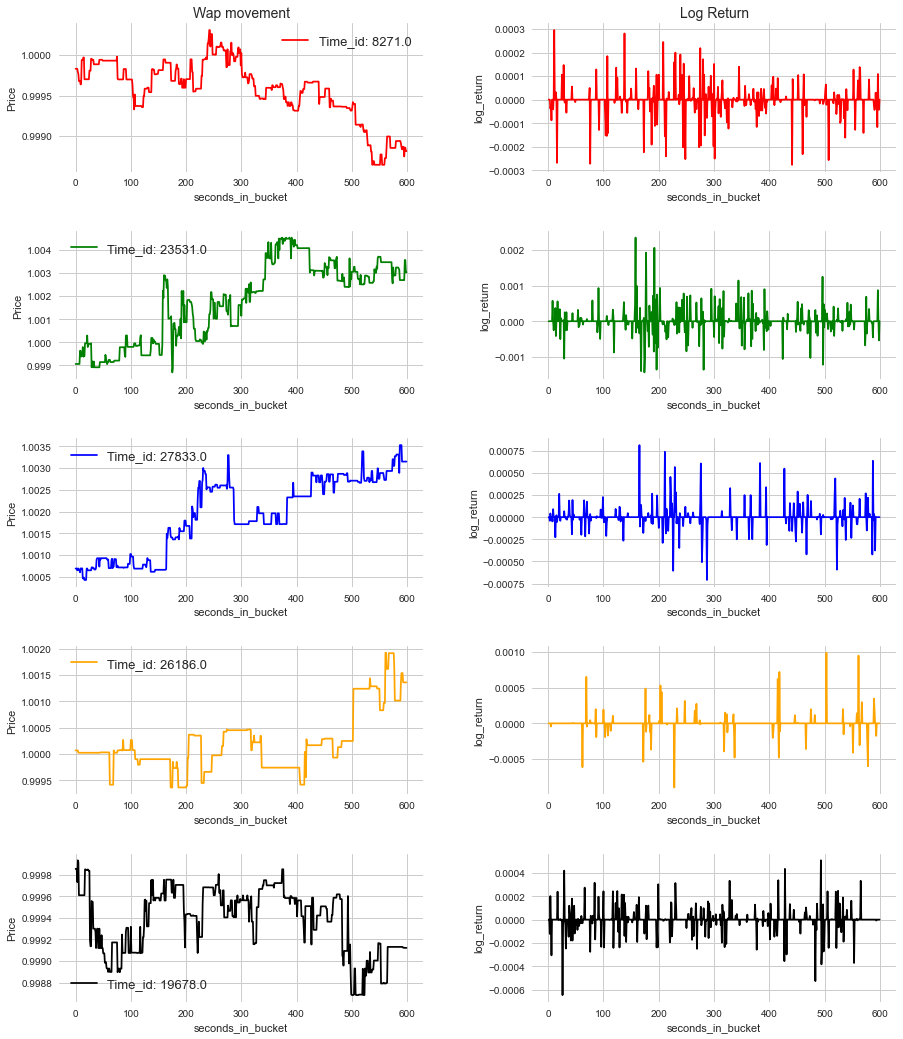

In [594]:
# Let's plot the wap and log returns

import random

fig, axes = plt.subplots(5,2, figsize = (15,18))
time_ids = random.sample(sorted(book['time_id'].unique()), 5)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

colors = {0: 'red', 1: 'green', 2: 'blue', 3:'orange', 4:'black'}

for i, time_id in enumerate(time_ids):
    
    ax = axes.flatten()[i*2]
    ax.plot(np.arange(0,600), book[book['time_id'] == time_id]['wap'], label = "Time_id: "+str(time_id), c= colors[i])
    ax.set_ylabel('Price')
    ax.set_xlabel('seconds_in_bucket')
    ax.legend(fontsize=13)
    
    ax1 = axes.flatten()[i*2+1]
    ax1.plot(np.arange(0,600), book[book['time_id'] == time_id]['log_return'], c= colors[i])
    ax1.set_ylabel('log_return')
    ax1.set_xlabel('seconds_in_bucket')
    if i==0:
        ax.set_title('Wap movement', fontsize=14)
        ax1.set_title("Log Return", fontsize=14)

plt.show()


**Observations**: 
1) The wap movements seem like random walks. wap is the weighted average price derived from the top bid-ask prices and sizes.

2) However, all the log returns do not look stationary. Some seems to have increase/decrease in variance.

Let's apply the adfuller test to check the stationarity of both the wap and log returns.


In [595]:
from statsmodels.tsa.stattools import adfuller

for i, time_id in enumerate(time_ids):
    results_wap = adfuller(book[book['time_id'] == time_id]['wap'])
    results_log_return = adfuller(book[book['time_id'] == time_id].dropna()['log_return'])
    
    print(f'Time id: {time_id}, p-values of Aug. Dickey Fuller test \n\tWap : {results_wap[1]:4.4f}\
    \n\tLog Return : {results_log_return[1]:4.4f}')
    

Time id: 8271.0, p-values of Aug. Dickey Fuller test 
	Wap : 0.6581    
	Log Return : 0.0000
Time id: 23531.0, p-values of Aug. Dickey Fuller test 
	Wap : 0.2380    
	Log Return : 0.0000
Time id: 27833.0, p-values of Aug. Dickey Fuller test 
	Wap : 0.6555    
	Log Return : 0.0000
Time id: 26186.0, p-values of Aug. Dickey Fuller test 
	Wap : 0.2316    
	Log Return : 0.0000
Time id: 19678.0, p-values of Aug. Dickey Fuller test 
	Wap : 0.1818    
	Log Return : 0.0000


As suspected, the Wap time series are non-stationary. But the log returns are all stationary. 

Let's plot the **acf** and **pacf** for the Wap prices.


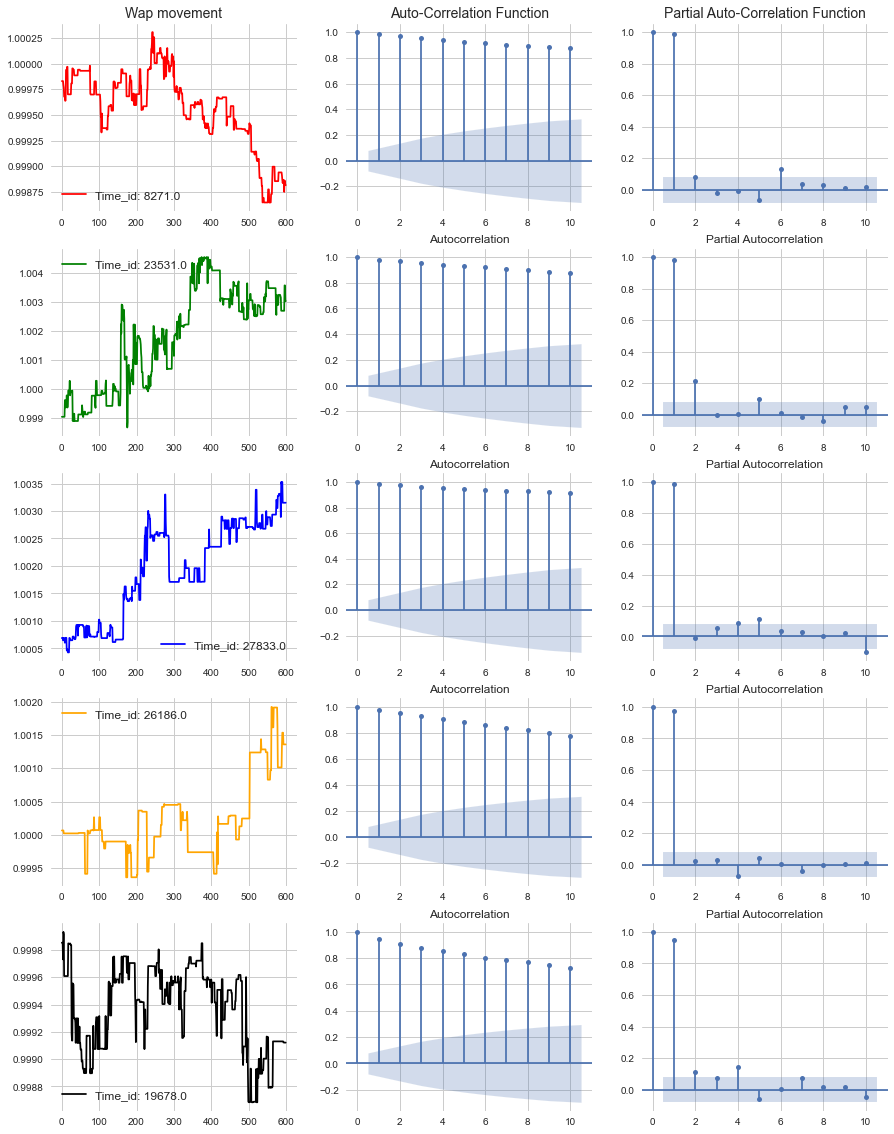

In [596]:
import random

fig, axes = plt.subplots(5,3, figsize = (15,20))

colors = {0: 'red', 1: 'green', 2: 'blue', 3:'orange', 4:'black'}

for i, time_id in enumerate(time_ids):
    
    ax = axes.flatten()[i*3]
    ax.plot(np.arange(0,600), book[book['time_id'] == time_id]['wap'], label = "Time_id: "+str(time_id), c= colors[i])
    ax.legend(fontsize=12)
    
    ax1 = axes.flatten()[i*3+1]
    plot_acf(book[book['time_id'] == time_id]['wap'], alpha=0.05, lags = 10, ax = ax1)
    
    ax2 = axes.flatten()[i*3+2]
    plot_pacf(book[book['time_id'] == time_id]['wap'], alpha=0.05, lags = 10, ax = ax2)
    
    if i==0:
        ax.set_title('Wap movement', fontsize=14)
        ax1.set_title("Auto-Correlation Function", fontsize=14)
        ax2.set_title("Partial Auto-Correlation Function", fontsize=14)
        
plt.show()

**Observation**: The above graphs show that the ACF trails off, while the PACF cuts off after 1 or 2 lags. So the WAP movement could be modelled with an AR(1) or AR(2) models.

### Features developed for book file

1) **abs_speed_book**: This is the absolute speed of price(wap) movement. It is like return, but has a time element to it. Simply, it is the price change divided by time taken for the price change. We take the absolute value. 

2) **abs_acceleration_book**: This is the absolute acceleration of price(wap) movement. Simply, it is the change in speed divided by time taken.

3) **hl_index_book**: This is the **highest** price during the time_id divided by the **lowest** price during that time_id. It gives a sense of the total swing in price during a given time_id.

4) **clop_index_book**: This is the **closing** price of a given time_id divided by the **opening** for that time_id. It gives a sense of net change in price during a given time_id.

5) **realized_vol_book**: This is realized volatility of the price during the given time_id. It is derived using the formula provided by Optiver. It is the square root of the sum total of squared log returns.


In [381]:
book_features = features_from_book(book)
book_features.head()

stock_id  time_id  abs_speed_book  abs_acceleration_book  hl_index_book  \
0         0      5.0        0.046769               0.087491       1.003481   
1         0     11.0        0.007391               0.014237       1.001135   
2         0     16.0        0.016550               0.031284       1.003665   
3         0     31.0        0.011988               0.023553       1.002972   
4         0     62.0        0.011892               0.023111       1.000928   

   clop_index_book  realized_vol_book  
0         1.002294           0.004499  
1         1.000360           0.001204  
2         0.997928           0.002369  
3         0.997176           0.002574  
4         0.999998           0.001895

Now let's look at the trade file. 

## Trade File

In [587]:
trade = pd.read_csv('../WIP_data/trade/train/stock_0_trade_train.csv')
trade.head()

time_id  seconds_in_bucket     price  size  order_count  stock_id
0        5                 21  1.002301   326           12         0
1        5                 46  1.002778   128            4         0
2        5                 50  1.002819    55            1         0
3        5                 57  1.003155   121            5         0
4        5                 68  1.003646     4            1         0

In [264]:
trade.shape

(99116, 6)

Sometimes, the 1st trade doesn't happen at '0' second. As such, the price change for this trade cannot be ascertained.

To be able to calculate the trade price change, we can initialize the trade price to wap in the second immediately before
the first trade. For e.g. in the below table the trade price for 'seconds_in_bucket = 20' is set equal to the wap price of 1.001443. The wap price is picked up from the book of this stock for the same time_id. There is no other data such as size, order_count etc. for this second and as such we leave those fields blank.


In [588]:


trade = initialize_trade_price(trade, book)
trade.head()

seconds_in_bucket  time_id     price   size  order_count  stock_id
0                 20      5.0  1.001443    NaN          NaN       NaN
1                 21      5.0  1.002301  326.0         12.0       0.0
2                 46      5.0  1.002778  128.0          4.0       0.0
3                 50      5.0  1.002819   55.0          1.0       0.0
4                 57      5.0  1.003155  121.0          5.0       0.0

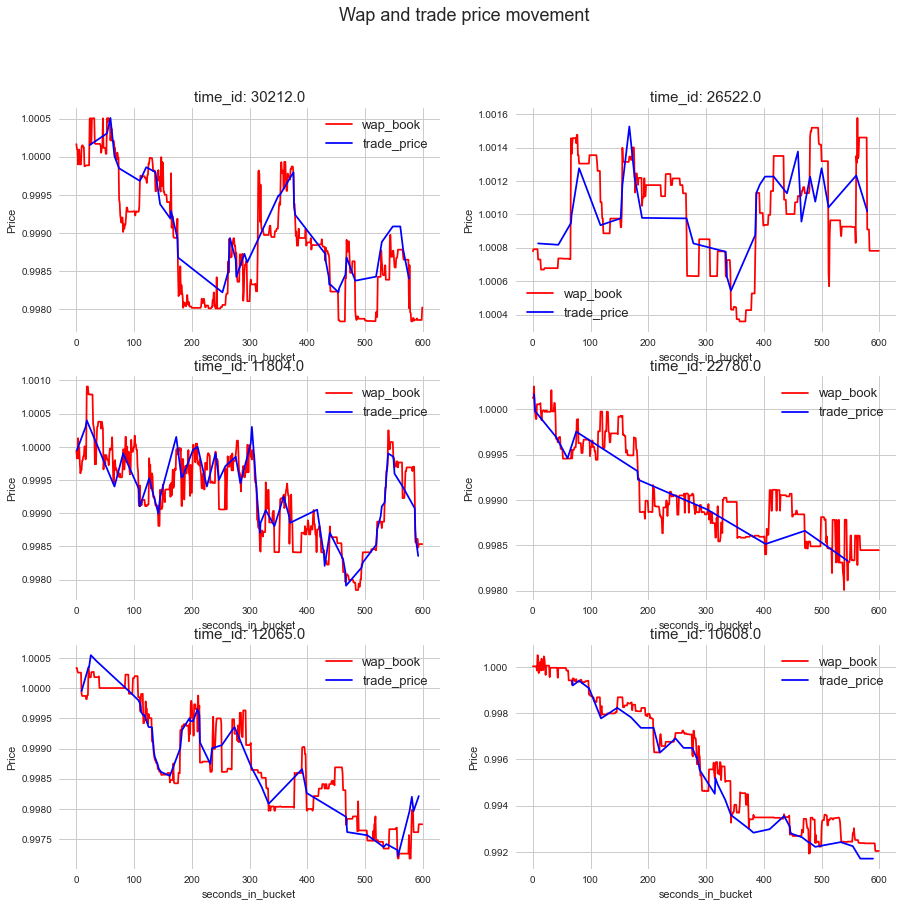

In [604]:
# Let's do a visualization to see how the trade price and wap(from book) move in the same time buckets

fig, axes = plt.subplots(3,2, figsize = (15,14))
time_ids = random.sample(sorted(book['time_id'].unique()), 6)

colors = {0: 'red', 1: 'green', 2: 'blue', 3:'orange', 4:'black'}


for i, time_id in enumerate(time_ids):
    
    ax = axes.flatten()[i]
    ax.plot(np.arange(0,600), book[book['time_id'] == time_id]['wap'], label = "wap_book", c= 'red')
    ax.plot(trade[trade['time_id'] == time_id]['seconds_in_bucket'], trade[trade['time_id'] == time_id]['price'], \
            label = "trade_price", c= 'blue')
    ax.set_ylabel('Price')
    ax.set_xlabel('seconds_in_bucket')
    ax.set_title('time_id: '+str(time_id), fontsize=15)
    ax.legend(fontsize=13)

plt.suptitle('Wap and trade price movement', fontsize=18)
plt.show()

**Observation:** From the charts above, it is clear that wap and trade price closely track each other. However, it is difficult to say which one drives the other. 

Now let's derive a few features using the trade file and then visualize how these trade features and some of the book features derived earlier are distributed. 

### Features developed for trade file

1) **abs_speed_trade**: This is the absolute speed of price movement in trade file. It is like return, but has a time element to it. Simply, it is the price change divided by time taken for the price change. We take the absolute value. 

2) **abs_acceleration_trade**: This is the absolute acceleration of price movement. Simply, it is the change in speed divided by time taken.

3) **hl_index_trade**: This is the **highest** price during the time_id divided by the **lowest** price during that time_id. It gives a sense of the total swing in traded price during a given time_id.

4) **clop_index_trade**: This is the **closing** price of a given time_id divided by the **opening** for that time_id. It gives a sense of net change in price during a given time_id.

5) **realized_vol_trade**: This is realized volatility of the traded price during the given time_id. It is derived using the formula provided by Optiver.

6) **turnover**: This is the total value of stocks traded in a given time_id. It is the price multiplied with size (no. of shares traded). 

7) **size**: This is the total no. of stocks traded in a given time_id. 

8) **order_count**: This is the total no. of orders executed in a given time_id.

9) **momentum**: Using a concept derived from physics, this is the **mass * velocity**. Mass here is taken as no. of shares traded, and velocity is the 'abs_speed_trade** as defined above. The momentum for a time_id is the sum total of momentum for each trade executed during the time_id. 

10) **abs_force_trade**: Using a concept derived from physics, this is the **mass * acceleration**. Mass here is taken as no. of shares traded, and acceleration is the 'abs_acceleration_trade** as defined above. The abs_force_trade for a time_id is the sum total of 'abs_force_trade' for each trade executed during the time_id. 


In [589]:

trade = trade_params(trade)
trade.head()

seconds_in_bucket  time_id     price   size  order_count  stock_id  \
1                 21      5.0  1.002301  326.0         12.0       0.0   
2                 46      5.0  1.002778  128.0          4.0       0.0   
3                 50      5.0  1.002819   55.0          1.0       0.0   
4                 57      5.0  1.003155  121.0          5.0       0.0   
5                 68      5.0  1.003646    4.0          1.0       0.0   

   log_return    turnover  abs_speed_trade  abs_acceleration_trade  momentum  \
1    0.000857  326.750224         0.000859            8.586558e-04  0.279922   
2    0.000475  128.355584         0.000019            3.358351e-05  0.002441   
3    0.000040   55.155017         0.000010            2.235750e-06  0.000557   
4    0.000336  121.381803         0.000048            5.429082e-06  0.005824   
5    0.000489    4.014584         0.000045            3.216057e-07  0.000178   

   abs_force_trade  
1         0.279922  
2         0.004299  
3         0.000123  
4         0.000657  
5         0.000001

In [385]:
trade_features = features_from_trade(trade)
trade_features.head()

time_id     turnover    size  order_count  abs_speed_trade  \
0      5.0  3190.139198  3179.0        110.0         0.002680   
1     11.0  1287.353777  1287.0         55.0         0.000546   
2     16.0  2158.608951  2161.0         68.0         0.001379   
3     31.0  1959.605540  1962.0         59.0         0.000638   
4     62.0  1790.254510  1791.0         89.0         0.000434   

   abs_acceleration_trade  momentum  abs_force_trade  hl_index_trade  \
0                0.001734  0.443241         0.344239        1.002374   
1                0.000226  0.054988         0.021759        1.001104   
2                0.000852  0.127383         0.061771        1.003072   
3                0.000442  0.050882         0.032270        1.002264   
4                0.000264  0.013473         0.002078        1.000793   

   clop_index_trade  realized_vol_trade  
0          1.001342            0.002181  
1          1.000703            0.000901  
2          0.997464            0.001964  
3          0.997741            0.001563  
4          0.999726            0.000876

In [386]:
# We merge the book and trade features into one file and also add the target from the train file to this dataframe

all_features = book_features.merge(trade_features, on='time_id', how='left')
all_features.head()

stock_id  time_id  abs_speed_book  abs_acceleration_book  hl_index_book  \
0         0      5.0        0.046769               0.087491       1.003481   
1         0     11.0        0.007391               0.014237       1.001135   
2         0     16.0        0.016550               0.031284       1.003665   
3         0     31.0        0.011988               0.023553       1.002972   
4         0     62.0        0.011892               0.023111       1.000928   

   clop_index_book  realized_vol_book     turnover    size  order_count  \
0         1.002294           0.004499  3190.139198  3179.0        110.0   
1         1.000360           0.001204  1287.353777  1287.0         55.0   
2         0.997928           0.002369  2158.608951  2161.0         68.0   
3         0.997176           0.002574  1959.605540  1962.0         59.0   
4         0.999998           0.001895  1790.254510  1791.0         89.0   

   abs_speed_trade  abs_acceleration_trade  momentum  abs_force_trade  \
0         0.002680                0.001734  0.443241         0.344239   
1         0.000546                0.000226  0.054988         0.021759   
2         0.001379                0.000852  0.127383         0.061771   
3         0.000638                0.000442  0.050882         0.032270   
4         0.000434                0.000264  0.013473         0.002078   

   hl_index_trade  clop_index_trade  realized_vol_trade  
0        1.002374          1.001342            0.002181  
1        1.001104          1.000703            0.000901  
2        1.003072          0.997464            0.001964  
3        1.002264          0.997741            0.001563  
4        1.000793          0.999726            0.000876

In [387]:
target = pd.read_csv('../WIP_data/target_training_data.csv')
target_stk = target[target['stock_id'] == 0][['time_id', 'target']]
target_stk.head()

time_id    target
0        5  0.004136
1       11  0.001445
2       16  0.002168
3       31  0.002195
4       62  0.001747

In [388]:
all_features = all_features.merge(target_stk, on='time_id', how='left')
all_features.head()

stock_id  time_id  abs_speed_book  abs_acceleration_book  hl_index_book  \
0         0      5.0        0.046769               0.087491       1.003481   
1         0     11.0        0.007391               0.014237       1.001135   
2         0     16.0        0.016550               0.031284       1.003665   
3         0     31.0        0.011988               0.023553       1.002972   
4         0     62.0        0.011892               0.023111       1.000928   

   clop_index_book  realized_vol_book     turnover    size  order_count  \
0         1.002294           0.004499  3190.139198  3179.0        110.0   
1         1.000360           0.001204  1287.353777  1287.0         55.0   
2         0.997928           0.002369  2158.608951  2161.0         68.0   
3         0.997176           0.002574  1959.605540  1962.0         59.0   
4         0.999998           0.001895  1790.254510  1791.0         89.0   

   abs_speed_trade  abs_acceleration_trade  momentum  abs_force_trade  \
0         0.002680                0.001734  0.443241         0.344239   
1         0.000546                0.000226  0.054988         0.021759   
2         0.001379                0.000852  0.127383         0.061771   
3         0.000638                0.000442  0.050882         0.032270   
4         0.000434                0.000264  0.013473         0.002078   

   hl_index_trade  clop_index_trade  realized_vol_trade    target  
0        1.002374          1.001342            0.002181  0.004136  
1        1.001104          1.000703            0.000901  0.001445  
2        1.003072          0.997464            0.001964  0.002168  
3        1.002264          0.997741            0.001563  0.002195  
4        1.000793          0.999726            0.000876  0.001747

## Distribution of Key Features

Let's us visualize the density plots of some of the features to understand how they are distributed.


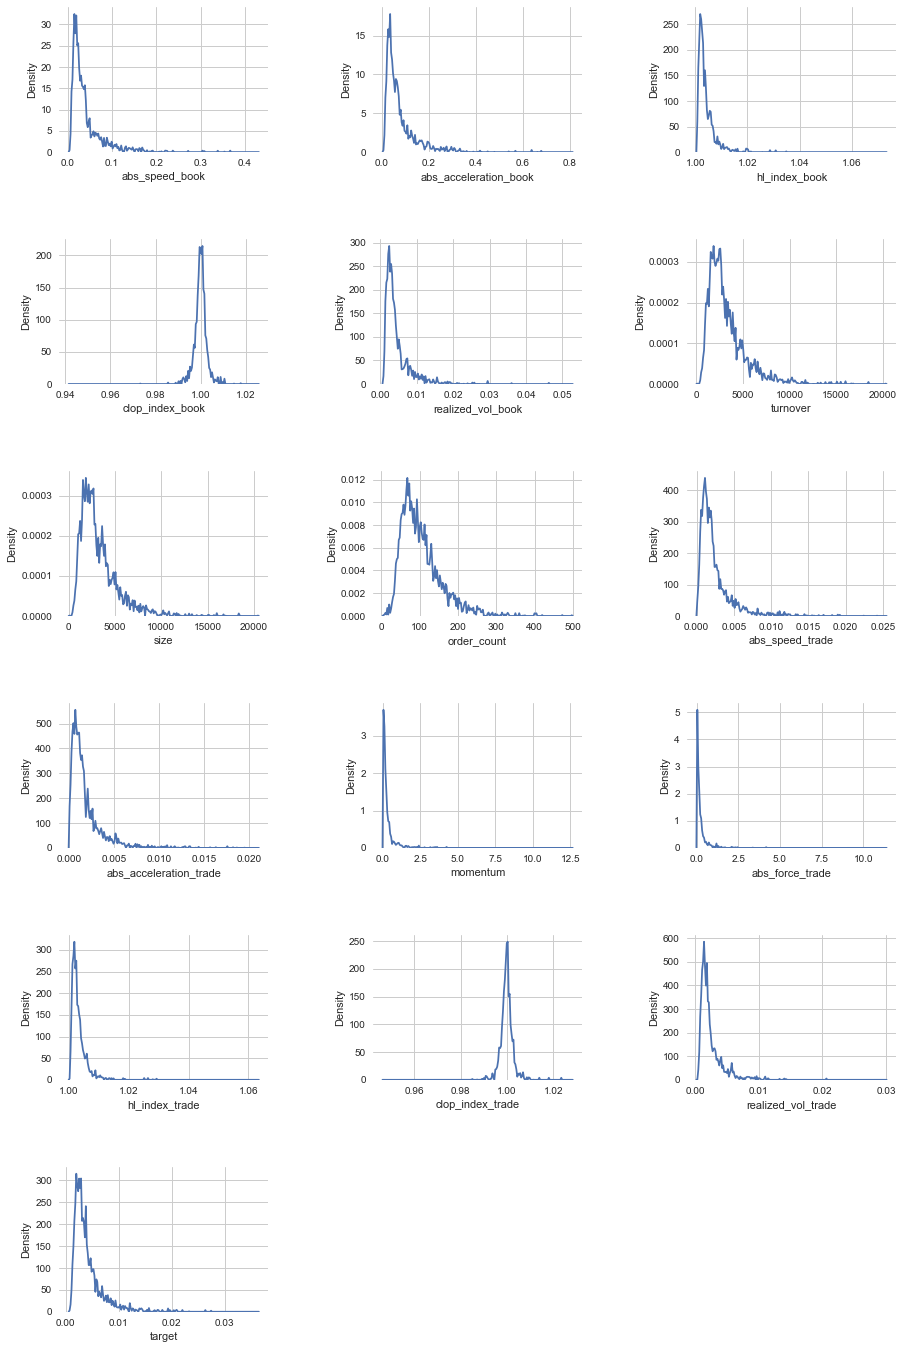

In [603]:
sns.set_style('whitegrid')
features = [feature for feature in all_features.columns \
            if feature not in ['time_id', 'stock_id']]
densityplots(all_features[all_features['stock_id'] ==0], features, ncol=3, figsize=(15, 24))

**Key Observations:**
* Many of the distributions are right tailed and understandably so. This is since for many features like abs_speed, realized_vol, we are taking absolute changes or squaring log_return for example.

* Some features have very high density around the central value e.g. realized_vol (both book and trade), high-low index(hl_index), the target etc.


Let's use the qq-plot to check whether these distributions are normal or not.


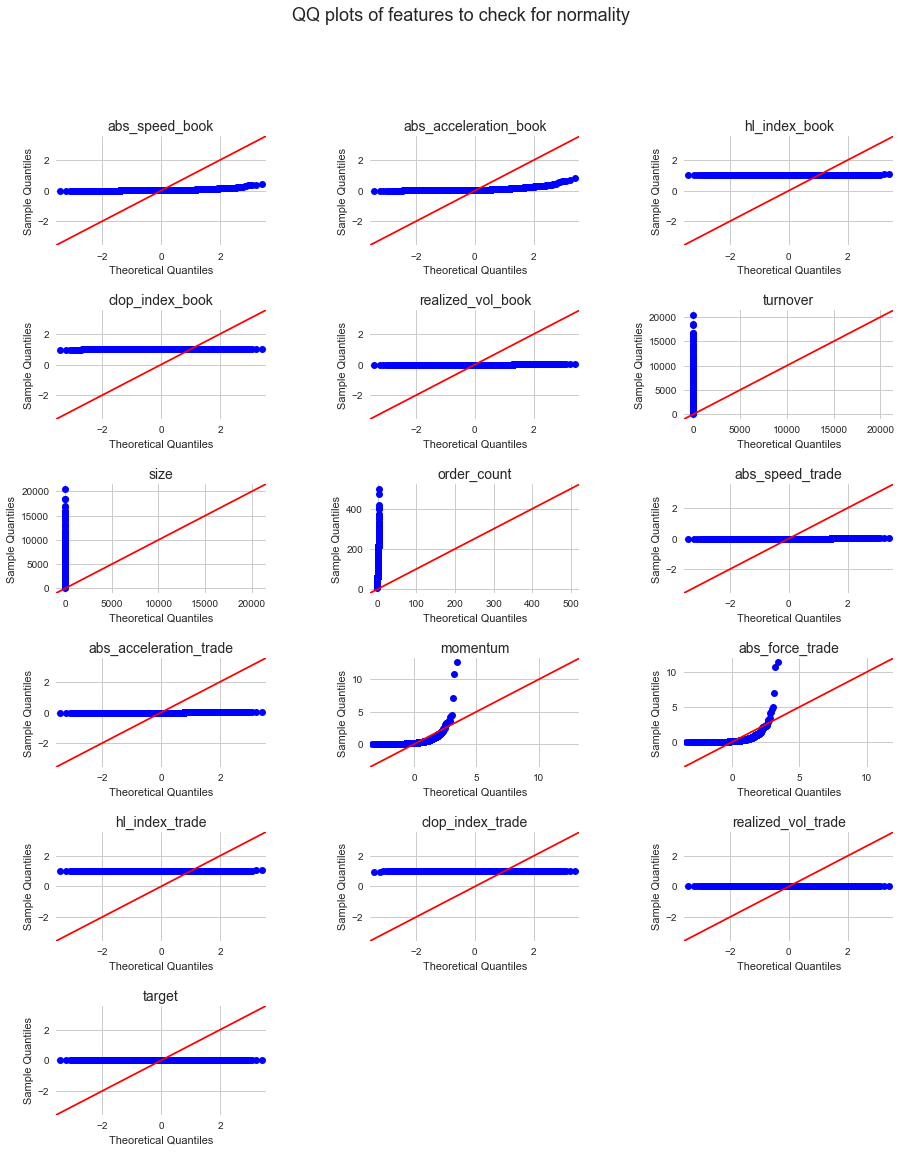

In [624]:
qqplots(all_features[all_features['stock_id'] ==0], features, ncol=3, figsize=(15, 18))

The qqplots show that the distributions are **not normal**. Let's confirm this using the Kolmogorov Smirnov test.


In [637]:
my_data = norm.rvs(size=1000)
for feature in features:
    ks_statistic, p_value = kstest(all_features[all_features['stock_id'] ==0][feature], 'norm')
    print(f'feature: {feature} --> p-value of KS test = {p_value:4.4f}')


feature: abs_speed_book --> p-value of KS test = 0.0000
feature: abs_acceleration_book --> p-value of KS test = 0.0000
feature: hl_index_book --> p-value of KS test = 0.0000
feature: clop_index_book --> p-value of KS test = 0.0000
feature: realized_vol_book --> p-value of KS test = 0.0000
feature: turnover --> p-value of KS test = 0.0000
feature: size --> p-value of KS test = 0.0000
feature: order_count --> p-value of KS test = 0.0000
feature: abs_speed_trade --> p-value of KS test = 0.0000
feature: abs_acceleration_trade --> p-value of KS test = 0.0000
feature: momentum --> p-value of KS test = 0.0000
feature: abs_force_trade --> p-value of KS test = 0.0000
feature: hl_index_trade --> p-value of KS test = 0.0000
feature: clop_index_trade --> p-value of KS test = 0.0000
feature: realized_vol_trade --> p-value of KS test = 0.0000
feature: target --> p-value of KS test = 0.0000


The p-value for all features is below 0.05, in fact it is 0.0. So we do not assume normal distribution.

For stock_id = 0, let's plot the correlations matrix for each of the above defined features and the target. Remember, the **target** is the realized volatility in wap price for the **10 minutes following the period** for which we are given the data. 


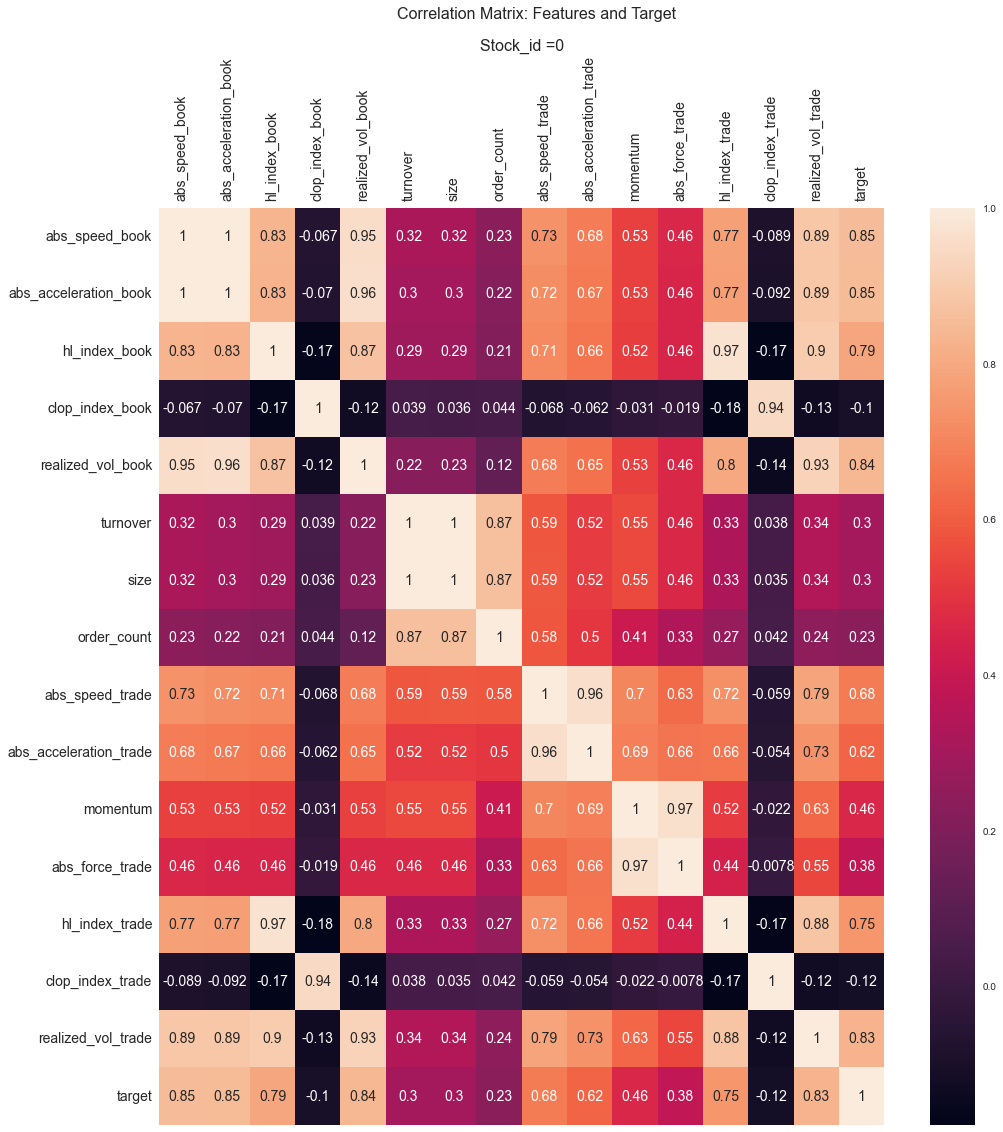

In [393]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(15,16))
ax=sns.heatmap(all_features.drop(['time_id', 'stock_id'], axis=1).corr(), annot=True, annot_kws={"size":14})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Features and Target\n", fontsize=16)
plt.title("Stock_id =" +str(all_features.stock_id.unique()[0]), fontsize=16)
plt.tight_layout()
plt.show()


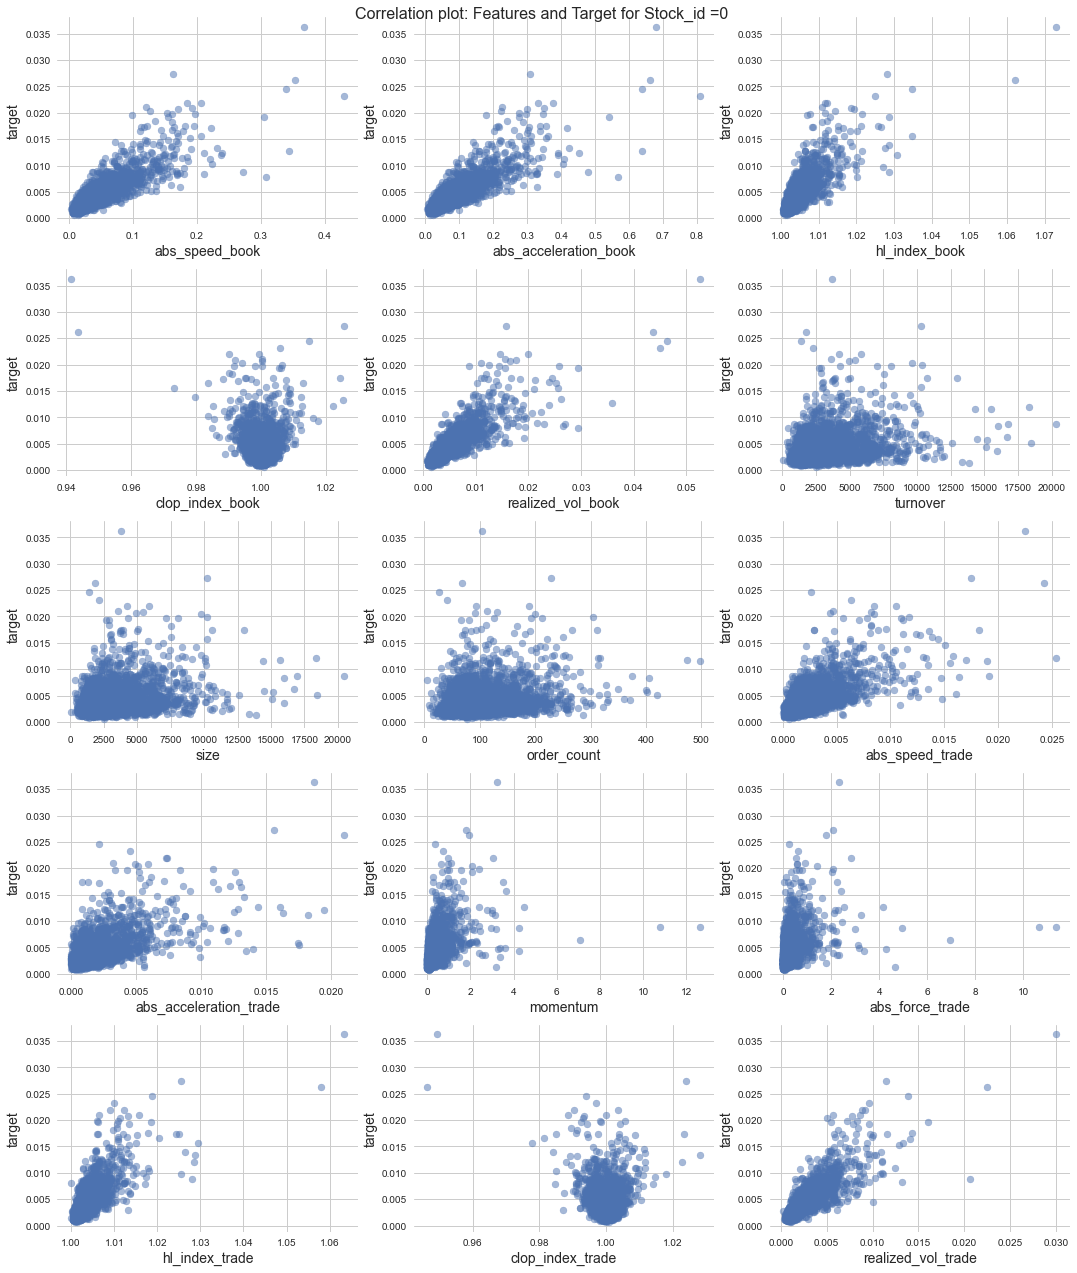

In [407]:
sns.set_style('whitegrid')
features = [feature for feature in all_features.columns \
            if feature not in ['time_id', 'stock_id', 'target']]
scatterplots(all_features, features, 'target', ncol=3, figsize=(15, 18))

**Key Observation from Correlation plots for stock_id = 0**

1. The top features that have significant correlations (based on the Pearson Correlation Coefficient) with the target are:

    * **abs_speed_book** : 0.85
    * **abs_acceleration_book**: 0.85
    * **realized_volatility_book**: 0.84
    * **realized_volatility_trade**: 0.83
    * **hl_index_book**: 0.79
    * **hl_index_trade**: 0.75
    

Now let's perform this analysis for another stock are see how much these features explain the changes in target.


# Stock_id = 23

Let's look into the book and trade files of this stock and understand and plot a few features.

## Book and Trade File Features

In [408]:
book_23 = pd.read_csv('../WIP_data/book/train/stock_23_book_train.csv')
book_23.head()


seconds_in_bucket  time_id  bid_price1  ask_price1  bid_price2  ask_price2  \
0                  0      5.0    1.000742    1.001738    1.000487    1.001759   
1                  1      5.0    1.000742    1.001738    1.000487    1.001759   
2                  2      5.0    1.000742    1.001738    1.000487    1.001759   
3                  3      5.0    1.000742    1.001738    1.000487    1.001759   
4                  4      5.0    1.000805    1.001738    1.000742    1.001759   

   bid_size1  ask_size1  bid_size2  ask_size2  stock_id  
0      102.0       35.0       71.0       29.0        23  
1      102.0       41.0       71.0       29.0        23  
2      102.0      149.0       71.0       29.0        23  
3      102.0      185.0       71.0       29.0        23  
4        2.0      185.0      101.0       29.0        23

In [409]:
book_23.shape

(1838400, 11)

In [410]:
book_23 = book_params(book_23)
book_features_23 = features_from_book(book_23)
book_features_23.head()

stock_id  time_id  abs_speed_book  abs_acceleration_book  hl_index_book  \
0        23      5.0        0.099877               0.174471       1.003681   
1        23     11.0        0.020340               0.037124       1.003323   
2        23     16.0        0.025441               0.045260       1.003147   
3        23     31.0        0.012577               0.023337       1.003963   
4        23     62.0        0.027872               0.049857       1.001429   

   clop_index_book  realized_vol_book  
0         1.000145           0.006895  
1         1.002554           0.002384  
2         1.001923           0.002206  
3         0.996814           0.001590  
4         1.000355           0.002247

In [411]:
trade_23 = pd.read_csv('../WIP_data/trade/train/stock_23_trade_train.csv')


trade_23 = initialize_trade_price(trade_23, book_23)
trade_23 = trade_params(trade_23)
trade_features_23 = features_from_trade(trade_23)
trade_features_23.head()


time_id      turnover     size  order_count  abs_speed_trade  \
0      5.0   4979.018914   4966.0        217.0         0.005788   
1     11.0   3555.480720   3550.0        143.0         0.000969   
2     16.0   7391.274080   7382.0        241.0         0.003447   
3     31.0   3550.763668   3560.0        101.0         0.000819   
4     62.0  12922.934375  12930.0        269.0         0.001296   

   abs_acceleration_trade  momentum  abs_force_trade  hl_index_trade  \
0                0.005407  0.333880         0.275353        1.003043   
1                0.001113  0.278477         0.296021        1.002544   
2                0.003270  0.352021         0.284275        1.003107   
3                0.000425  0.103166         0.047227        1.003052   
4                0.000948  0.201096         0.174515        1.001318   

   clop_index_trade  realized_vol_trade  
0          1.000169            0.002790  
1          1.002449            0.001107  
2          1.001809            0.001381  
3          0.997072            0.001243  
4          1.000117            0.000948

In [412]:
all_features_23 = book_features_23.merge(trade_features_23, on='time_id', how='left')
target_stk_23 = target[target['stock_id'] == 23][['time_id', 'target']]

all_features_23 = all_features_23.merge(target_stk_23, on='time_id', how='left')


In [413]:
all_features_23.head()

stock_id  time_id  abs_speed_book  abs_acceleration_book  hl_index_book  \
0        23      5.0        0.099877               0.174471       1.003681   
1        23     11.0        0.020340               0.037124       1.003323   
2        23     16.0        0.025441               0.045260       1.003147   
3        23     31.0        0.012577               0.023337       1.003963   
4        23     62.0        0.027872               0.049857       1.001429   

   clop_index_book  realized_vol_book      turnover     size  order_count  \
0         1.000145           0.006895   4979.018914   4966.0        217.0   
1         1.002554           0.002384   3555.480720   3550.0        143.0   
2         1.001923           0.002206   7391.274080   7382.0        241.0   
3         0.996814           0.001590   3550.763668   3560.0        101.0   
4         1.000355           0.002247  12922.934375  12930.0        269.0   

   abs_speed_trade  abs_acceleration_trade  momentum  abs_force_trade  \
0         0.005788                0.005407  0.333880         0.275353   
1         0.000969                0.001113  0.278477         0.296021   
2         0.003447                0.003270  0.352021         0.284275   
3         0.000819                0.000425  0.103166         0.047227   
4         0.001296                0.000948  0.201096         0.174515   

   hl_index_trade  clop_index_trade  realized_vol_trade    target  
0        1.003043          1.000169            0.002790  0.006338  
1        1.002544          1.002449            0.001107  0.002464  
2        1.003107          1.001809            0.001381  0.002465  
3        1.003052          0.997072            0.001243  0.002127  
4        1.001318          1.000117            0.000948  0.001871

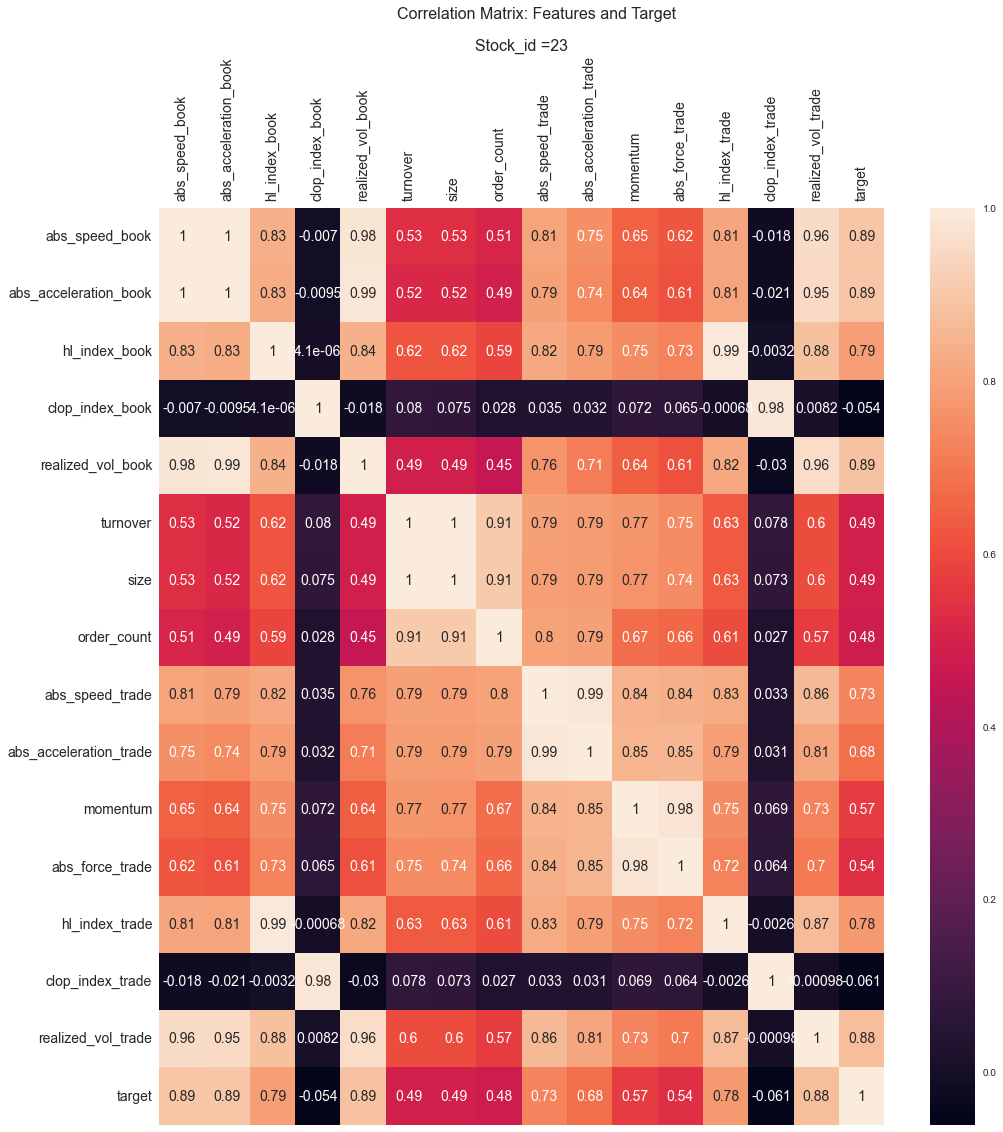

In [415]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(15,16))
ax=sns.heatmap(all_features_23.drop(['time_id', 'stock_id'], axis=1).corr(), annot=True, annot_kws={"size":14})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Features and Target\n", fontsize=16)
plt.title("Stock_id =" +str(all_features_23.stock_id.unique()[0]), fontsize=16)
plt.tight_layout()
plt.show()

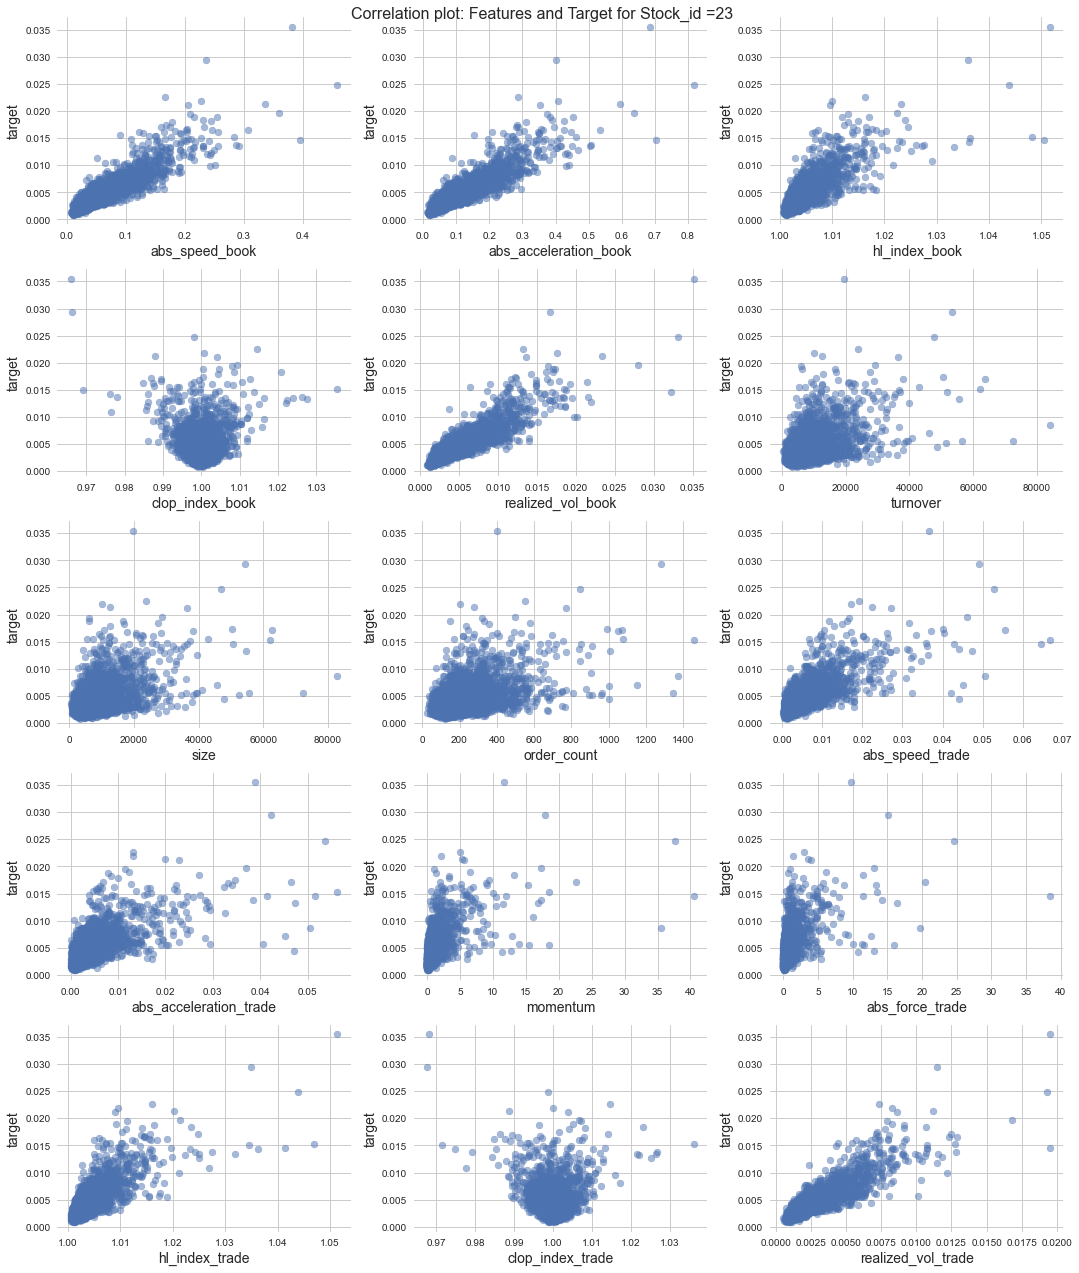

In [416]:
sns.set_style('whitegrid')
features = [feature for feature in all_features_23.columns \
            if feature not in ['time_id', 'stock_id', 'target']]
scatterplots(all_features_23, features, 'target', ncol=3, figsize=(15, 18))


In [433]:
datapath = "../WIP_data/features"

save_file(all_features, 'stock_0_features.csv', datapath)
save_file(all_features_23, 'stock_23_features.csv', datapath)

Writing file.  "../WIP_data/features\stock_0_features.csv"
Writing file.  "../WIP_data/features\stock_23_features.csv"


The correlation values and plots of stock_id = 23 are quite similar to stock_id = 0. 

Some others questions for which it would interesting to find answers in the exploratory analysis are:

   * **How is volatility of different stocks connected ? Are there clusters of stocks with similar volatility levels?**
   * **How is an individual stock's volatility connected to the market's overall volatility ?** 

Let's try to answers these questions now. For the purpose of this analysis, we shall randomly select **30 stocks** from the 112 stocks.


In [428]:
import random

file_list = glob.glob('../Raw_data/book_train.parquet/stock_id=*')

stock_ids = [int(filename.split('=')[1]) for filename in file_list]

stocks_30 = random.sample(stock_ids, 30)

In [434]:

all_features = pd.DataFrame()

for stock_id in stocks_30:
    book_file = "../WIP_data/book/train/stock_"+str(stock_id)+"_book_train.csv"
    trade_file = "../WIP_data/trade/train/stock_"+str(stock_id)+"_trade_train.csv"
    
    book = pd.read_csv(book_file)
    trade = pd.read_csv(trade_file)
    
    book = book_params(book)
    book_features = features_from_book(book)
    
    trade = initialize_trade_price(trade, book)
    trade = trade_params(trade)
    trade_features = features_from_trade(trade)
    
    all_features_new = book_features.merge(trade_features, on='time_id', how='left')
    target_stk = target[target['stock_id'] == stock_id][['time_id', 'target']]
    all_features_new = all_features_new.merge(target_stk, on='time_id', how='left')
    
    all_features = pd.concat([all_features, all_features_new], ignore_index=True)
    
    
    

In [435]:
all_features.head()

stock_id  time_id  abs_speed_book  abs_acceleration_book  hl_index_book  \
0        41      5.0        0.026161               0.043898       1.002797   
1        41     11.0        0.007426               0.013091       1.001303   
2        41     16.0        0.021184               0.034841       1.002339   
3        41     31.0        0.009947               0.017213       1.001335   
4        41     62.0        0.010449               0.018401       1.001212   

   clop_index_book  realized_vol_book      turnover     size  order_count  \
0         1.000685           0.001997  61839.793713  61738.0        466.0   
1         1.000608           0.000901  43319.609619  43293.0        379.0   
2         0.998842           0.001540  31817.914888  31839.0        312.0   
3         0.999243           0.001127  34860.666440  34898.0        279.0   
4         1.000185           0.001148  21622.144369  21619.0        226.0   

   abs_speed_trade  abs_acceleration_trade  momentum  abs_force_trade  \
0         0.002764                0.002115  2.392969         1.398003   
1         0.000859                0.000695  1.512866         1.163004   
2         0.003209                0.002397  1.455099         1.115874   
3         0.000525                0.000206  0.593284         0.173273   
4         0.000631                0.000455  0.692065         0.506941   

   hl_index_trade  clop_index_trade  realized_vol_trade    target  
0        1.002674          1.000668            0.001347  0.002184  
1        1.001230          1.000615            0.000810  0.000652  
2        1.002370          0.998709            0.001382  0.001774  
3        1.001337          0.999110            0.001033  0.000841  
4        1.001118          1.000000            0.000885  0.001509

In [438]:
save_file(all_features, '30_stock_features.csv', datapath)


Writing file.  "../WIP_data/features\30_stock_features.csv"


In [446]:
realized_vol = all_features.pivot_table(index='time_id', columns = 'stock_id', values = 'realized_vol_book').reset_index()
realized_vol.columns = ['stock_'+str(col) if col != 'time_id' else col for col in realized_vol.columns]
realized_vol.head()

time_id   stock_1   stock_4   stock_5   stock_8  stock_14  stock_22  \
0      5.0  0.006245  0.005640  0.005366  0.009680  0.002237  0.004934   
1     11.0  0.002305  0.002037  0.001776  0.003838  0.001132  0.002106   
2     16.0  0.002517  0.002709  0.002458  0.001580  0.002311  0.003028   
3     31.0  0.003570  0.002182  0.004464  0.003800  0.001712  0.002583   
4     62.0  0.002903  0.002710  0.002807  0.005626  0.001222  0.001856   

   stock_26  stock_34  stock_35  ...  stock_95  stock_99  stock_101  \
0  0.003899  0.002553  0.003079  ...  0.004168  0.002085   0.005351   
1  0.001349  0.001288  0.001654  ...  0.001606  0.001024   0.002536   
2  0.001790  0.001520  0.001993  ...  0.001834  0.001888   0.002198   
3  0.001963  0.001345  0.002155  ...  0.001881  0.001481   0.004751   
4  0.001197  0.001087  0.002239  ...  0.001627  0.000995   0.002789   

   stock_102  stock_103  stock_104  stock_108  stock_110  stock_116  stock_126  
0   0.006935   0.005832   0.003629   0.002976   0.005126   0.009201   0.007255  
1   0.001705   0.001986   0.001366   0.001174   0.003623   0.002097   0.003294  
2   0.002623   0.002314   0.002908   0.002395   0.002230   0.002270   0.002719  
3   0.001823   0.001689   0.002152   0.001914   0.003695   0.003180   0.004418  
4   0.002034   0.002164   0.000687   0.001695   0.003175   0.003445   0.002538  

[5 rows x 31 columns]

In [483]:
realized_vol.shape

(3064, 32)

In [484]:
realized_vol.dropna(how='any', inplace=True)
realized_vol.shape

(3054, 32)

In [485]:
realized_vol['market_average'] = realized_vol.drop(columns = ['time_id']).mean(axis=1)
realized_vol.head()

time_id   stock_1   stock_4   stock_5   stock_8  stock_14  stock_22  \
0      5.0  0.006245  0.005640  0.005366  0.009680  0.002237  0.004934   
1     11.0  0.002305  0.002037  0.001776  0.003838  0.001132  0.002106   
2     16.0  0.002517  0.002709  0.002458  0.001580  0.002311  0.003028   
3     31.0  0.003570  0.002182  0.004464  0.003800  0.001712  0.002583   
4     62.0  0.002903  0.002710  0.002807  0.005626  0.001222  0.001856   

   stock_26  stock_34  stock_35  ...  stock_99  stock_101  stock_102  \
0  0.003899  0.002553  0.003079  ...  0.002085   0.005351   0.006935   
1  0.001349  0.001288  0.001654  ...  0.001024   0.002536   0.001705   
2  0.001790  0.001520  0.001993  ...  0.001888   0.002198   0.002623   
3  0.001963  0.001345  0.002155  ...  0.001481   0.004751   0.001823   
4  0.001197  0.001087  0.002239  ...  0.000995   0.002789   0.002034   

   stock_103  stock_104  stock_108  stock_110  stock_116  stock_126  \
0   0.005832   0.003629   0.002976   0.005126   0.009201   0.007255   
1   0.001986   0.001366   0.001174   0.003623   0.002097   0.003294   
2   0.002314   0.002908   0.002395   0.002230   0.002270   0.002719   
3   0.001689   0.002152   0.001914   0.003695   0.003180   0.004418   
4   0.002164   0.000687   0.001695   0.003175   0.003445   0.002538   

   market_average  
0        0.004697  
1        0.002158  
2        0.002249  
3        0.002729  
4        0.002228  

[5 rows x 32 columns]

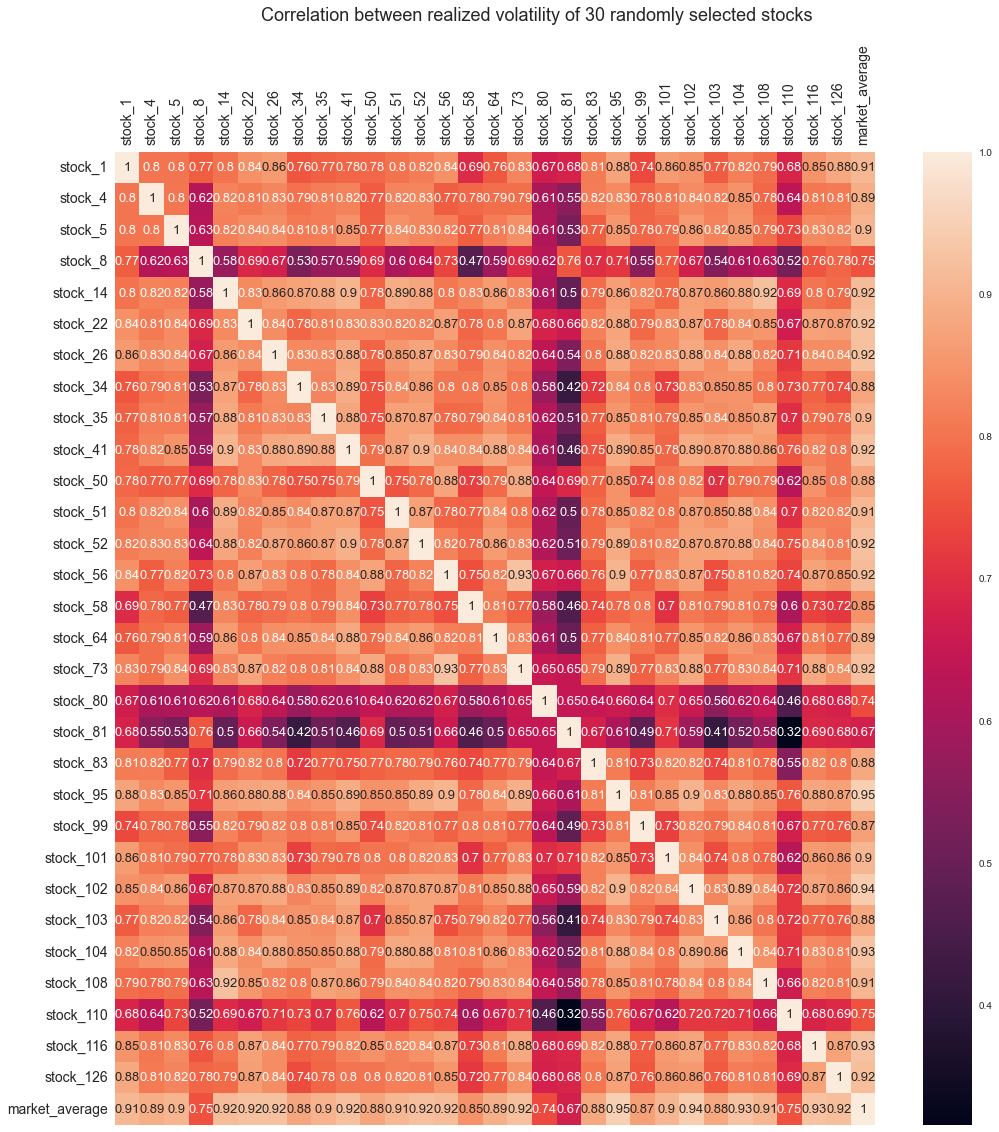

In [486]:

sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(15,16))
ax=sns.heatmap(realized_vol.drop(['time_id'], axis=1).corr(), annot=True, annot_kws={"size":13})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation between realized volatility of 30 randomly selected stocks\n", fontsize=18)
#plt.title("Stock_id =" +str(all_features_23.stock_id.unique()[0]), fontsize=16)
plt.tight_layout()
plt.show()


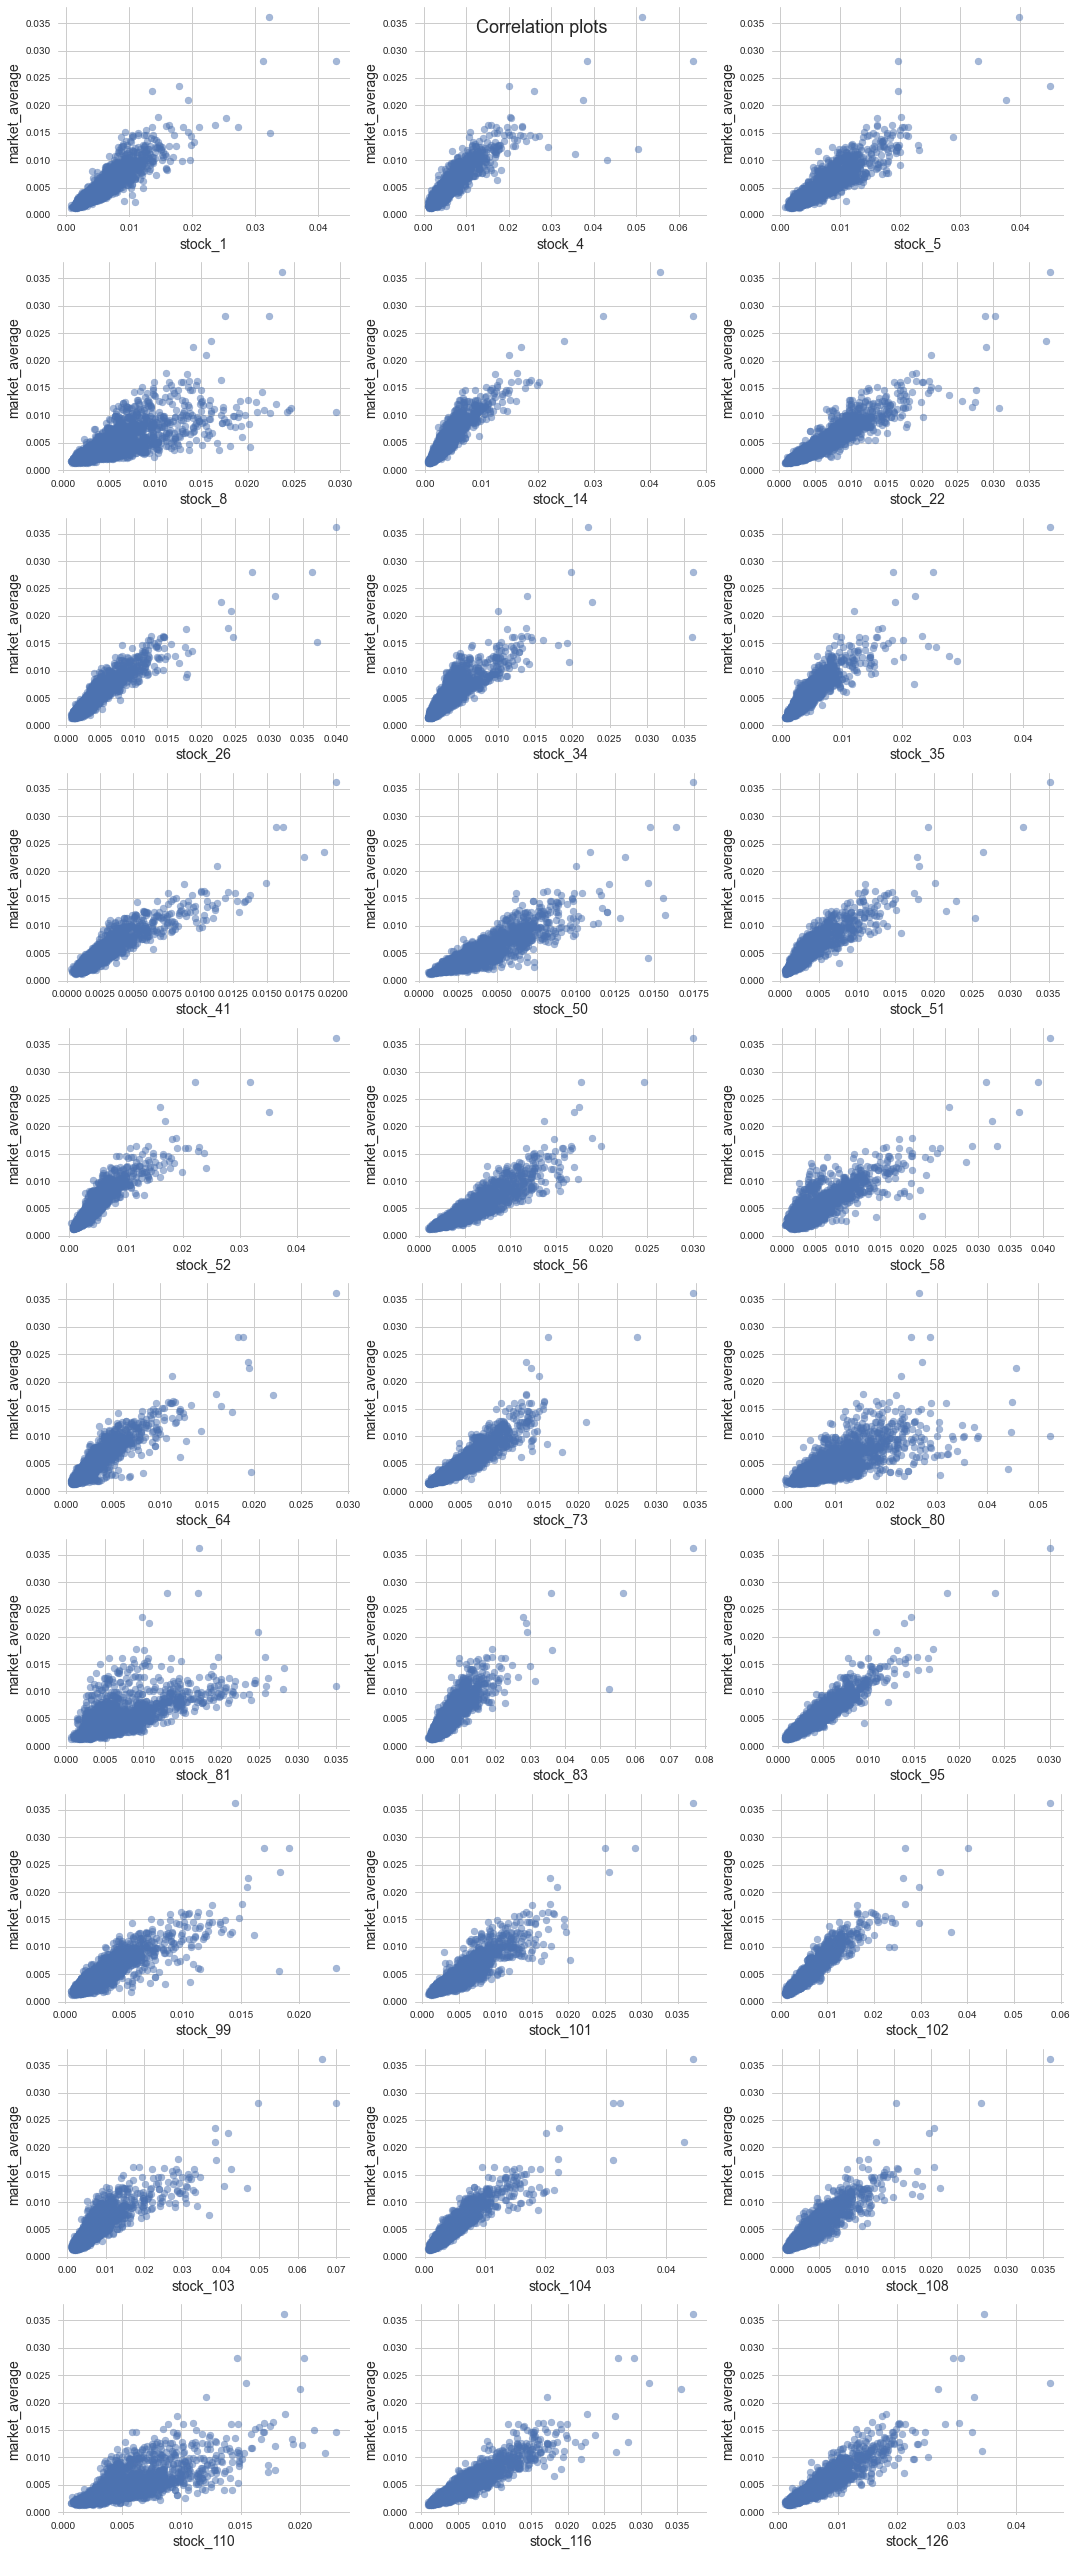

In [487]:

sns.set_style('whitegrid')
features = [feature for feature in realized_vol.columns \
            if feature not in ['time_id', 'stock_id', 'market_average']]
scatterplots(realized_vol, features, 'market_average', ncol=3, figsize=(15, 36))


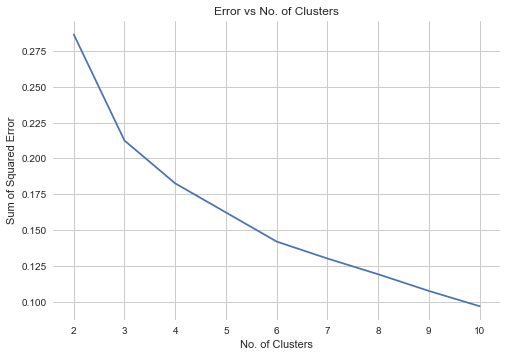

In [491]:
from sklearn.cluster import KMeans
import numpy as np

x_cols = realized_vol.drop('time_id', axis=1).T.to_numpy()
ss_error = []

K_vals = np.arange(2,11)
for K in K_vals:
    model = KMeans(n_clusters = K, random_state=123)
    labels = model.fit_predict(x_cols)
    centroids = model.cluster_centers_
    ss_error.append(np.sum((x_cols - centroids[labels])**2))


plt.plot(K_vals, ss_error)
plt.xlabel('No. of Clusters')
plt.ylabel('Sum of Squared Error')
plt.title('Error vs No. of Clusters')
plt.show()

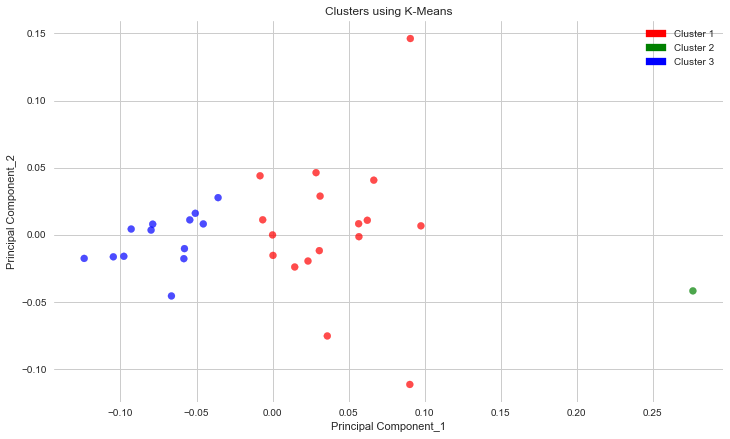

In [494]:
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

kmeans = KMeans(n_clusters=3, random_state = 123)
labels = kmeans.fit_predict(x_cols)
    
model = PCA(n_components=2)
model.fit(x_cols)
transformed = model.transform(x_cols)

df_transformed = pd.DataFrame({'stock': np.array(realized_vol.columns[1:]), 'cluster': labels, \
                               'x': transformed[:,0], 'y': transformed[:,1]})

fig, ax = plt.subplots(1,1, figsize=(12,7))
colors = {0: 'red', 1: 'green', 2: 'blue'}


scatter = ax.scatter(df_transformed['x'], df_transformed['y'], c= df_transformed['cluster'].map(colors), alpha = 0.7)

red_patch = mpatches.Patch(color='red', label = 'Cluster 1')
green_patch = mpatches.Patch(color='green', label = 'Cluster 2')
blue_patch = mpatches.Patch(color='blue', label = 'Cluster 3')
#yellow_patch = mpatches.Patch(color='yellow', label = 'Cluster 4')

ax.legend(handles=[red_patch, green_patch, blue_patch])
ax.set_xlabel('Principal Component_1')
ax.set_ylabel('Principal Component_2')
ax.set_title('Clusters using K-Means')
plt.show()


## stock_id = 10

In [496]:
import random

file_list = glob.glob('../Raw_data/book_train.parquet/stock_id=*')

stock_ids = [int(filename.split('=')[1]) for filename in file_list]

all_features = pd.DataFrame()

for stock_id in stock_ids:
    book_file = "../WIP_data/book/train/stock_"+str(stock_id)+"_book_train.csv"
    trade_file = "../WIP_data/trade/train/stock_"+str(stock_id)+"_trade_train.csv"
    
    book = pd.read_csv(book_file)
    trade = pd.read_csv(trade_file)
    
    book = book_params(book)
    book_features = features_from_book(book)
    
    trade = initialize_trade_price(trade, book)
    trade = trade_params(trade)
    trade_features = features_from_trade(trade)
    
    all_features_new = book_features.merge(trade_features, on='time_id', how='left')
    target_stk = target[target['stock_id'] == stock_id][['time_id', 'target']]
    all_features_new = all_features_new.merge(target_stk, on='time_id', how='left')
    
    all_features = pd.concat([all_features, all_features_new], ignore_index=True)

save_file(all_features, 'all_stock_features.csv', datapath)

Writing file.  "../WIP_data/features\all_stock_features.csv"


In [497]:
all_features.head()

stock_id  time_id  abs_speed_book  abs_acceleration_book  hl_index_book  \
0         0      5.0        0.046769               0.087491       1.003481   
1         0     11.0        0.007391               0.014237       1.001135   
2         0     16.0        0.016550               0.031284       1.003665   
3         0     31.0        0.011988               0.023553       1.002972   
4         0     62.0        0.011892               0.023111       1.000928   

   clop_index_book  realized_vol_book     turnover    size  order_count  \
0         1.002294           0.004499  3190.139198  3179.0        110.0   
1         1.000360           0.001204  1287.353777  1287.0         55.0   
2         0.997928           0.002369  2158.608951  2161.0         68.0   
3         0.997176           0.002574  1959.605540  1962.0         59.0   
4         0.999998           0.001895  1790.254510  1791.0         89.0   

   abs_speed_trade  abs_acceleration_trade  momentum  abs_force_trade  \
0         0.002680                0.001734  0.443241         0.344239   
1         0.000546                0.000226  0.054988         0.021759   
2         0.001379                0.000852  0.127383         0.061771   
3         0.000638                0.000442  0.050882         0.032270   
4         0.000434                0.000264  0.013473         0.002078   

   hl_index_trade  clop_index_trade  realized_vol_trade    target  
0        1.002374          1.001342            0.002181  0.004136  
1        1.001104          1.000703            0.000901  0.001445  
2        1.003072          0.997464            0.001964  0.002168  
3        1.002264          0.997741            0.001563  0.002195  
4        1.000793          0.999726            0.000876  0.001747

In [514]:
def plot_cluster_sse(df, features, ncols=None, figsize=(15,9)):
    
    if ncols == None:
        ncols = len(features)
    nrows = int(np.ceil(len(features)/ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("Error vs No. of clusters\n", fontsize=18)
    
    for idx, feature in enumerate(features):
        
        df_feature = df.pivot_table(index='time_id', columns = 'stock_id', values = feature).reset_index()
        df_feature.columns = ['stock_'+str(col) if col != 'time_id' else col for col in df_feature.columns]
        df_feature.dropna(how='any', inplace=True)
        
        x_cols = df_feature.drop('time_id', axis=1).T.to_numpy()
        ss_error = []

        K_vals = np.arange(2,11)
        for K in K_vals:
            model = KMeans(n_clusters = K, random_state=123)
            labels = model.fit_predict(x_cols)
            centroids = model.cluster_centers_
            ss_error.append(np.sum((x_cols - centroids[labels])**2))

        ax = axes.flatten()[idx]
        ax.plot(K_vals, ss_error)
        ax.set_xlabel('No. of Clusters')
        ax.set_ylabel('Sum of Squared Error')
        ax.set_title('Feature: '+feature, fontsize=14)
    
    nsubplots = nrows * ncols    
    for empty in range(idx+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    

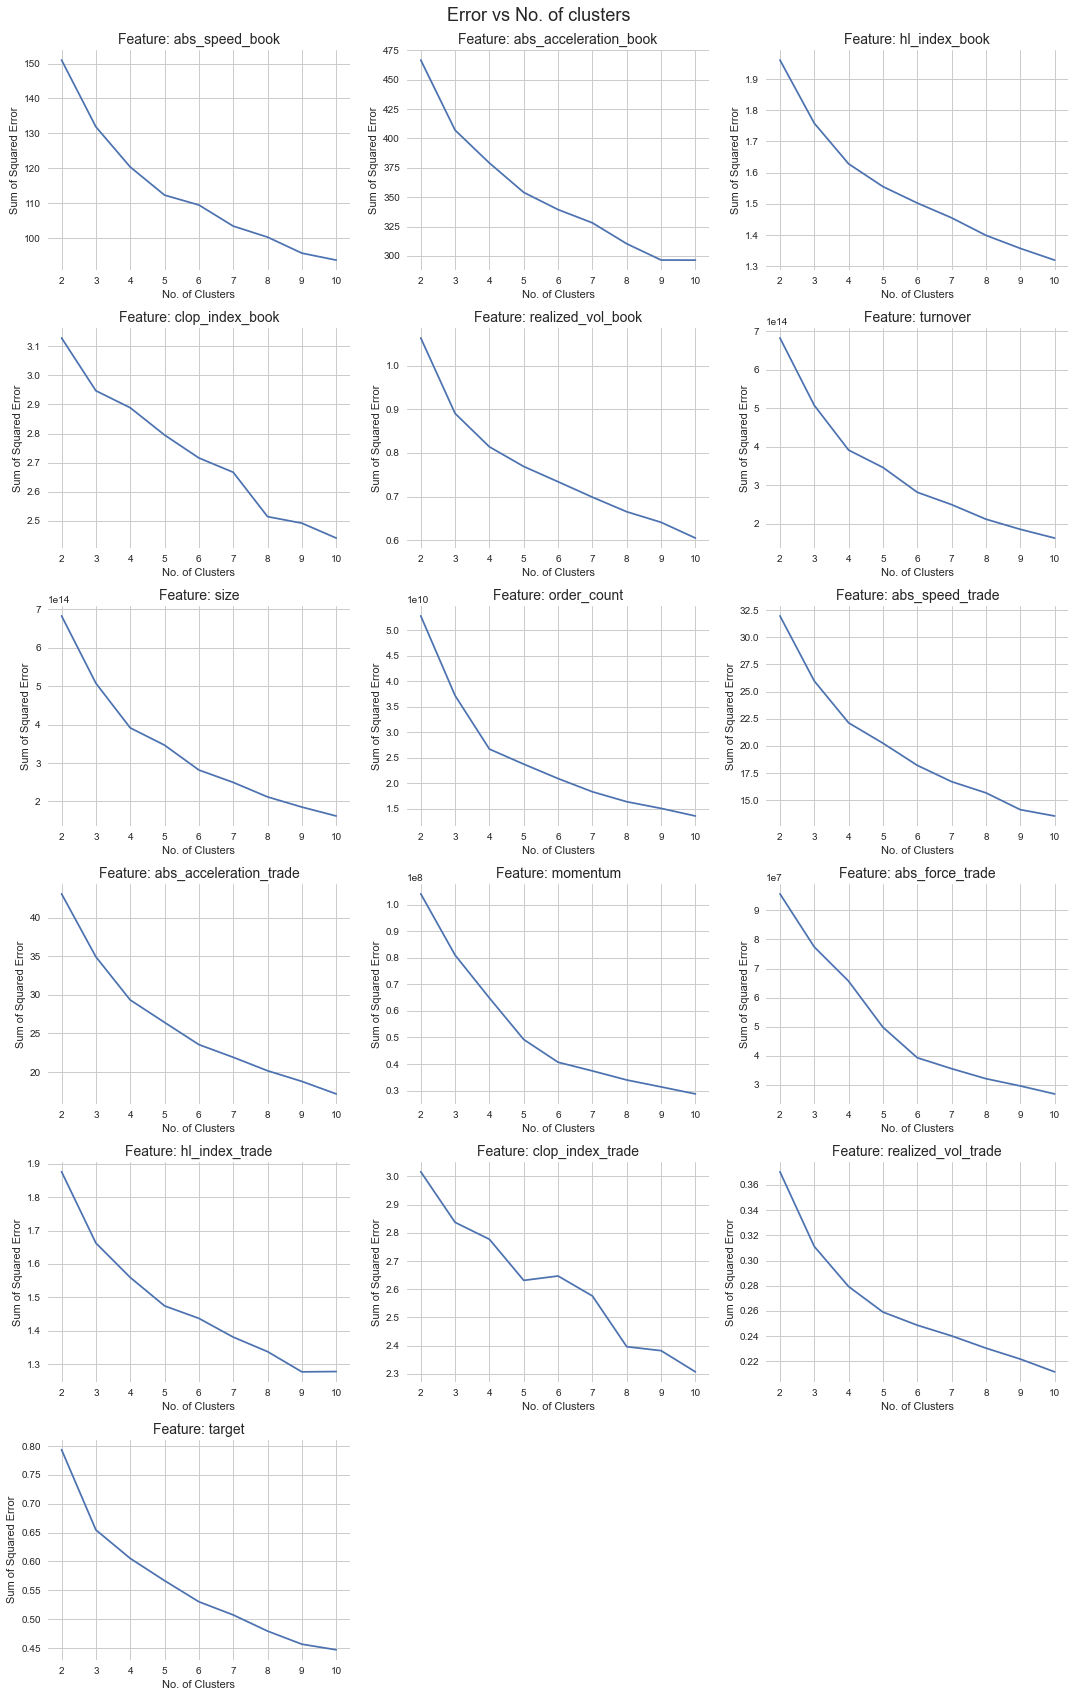

In [515]:
features = [feature for feature in all_features.columns \
            if feature not in ['time_id', 'stock_id']]

plot_cluster_sse(all_features, features, ncols=3, figsize=(15,24))


In [520]:
def plot_clusters(df, features, nclusters = 4, ncols=None, figsize=(15,9)):
    
    if ncols == None:
        ncols = len(features)
    nrows = int(np.ceil(len(features)/ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("No. of clusters by feature\n", fontsize=18)
    colors = {0: 'red', 1: 'green', 2: 'blue', 3:'orange'}
    red_patch = mpatches.Patch(color='red', label = 'Cluster 1')
    green_patch = mpatches.Patch(color='green', label = 'Cluster 2')
    blue_patch = mpatches.Patch(color='blue', label = 'Cluster 3')
    orange_patch = mpatches.Patch(color='orange', label = 'Cluster 4')

    for idx, feature in enumerate(features):
        
        df_feature = df.pivot_table(index='time_id', columns = 'stock_id', values = feature).reset_index()
        df_feature.columns = ['stock_'+str(col) if col != 'time_id' else col for col in df_feature.columns]
        df_feature.dropna(how='any', inplace=True)
        
        x_cols = df_feature.drop('time_id', axis=1).T.to_numpy()
        
        kmeans = KMeans(n_clusters=nclusters, random_state = 123)
        labels = kmeans.fit_predict(x_cols)
        model = PCA(n_components=2)
        model.fit(x_cols)
        transformed = model.transform(x_cols)

        df_transformed = pd.DataFrame({'stock': np.array(df_feature.columns[1:]), 'cluster': labels, \
                               'x': transformed[:,0], 'y': transformed[:,1]})
        
        ax = axes.flatten()[idx]
        ax.scatter(df_transformed['x'], df_transformed['y'], c= df_transformed['cluster'].map(colors), alpha = 0.7)

        #ax.legend(handles=[red_patch, green_patch, blue_patch, orange_patch])
        ax.set_xlabel('Principal Component_1')
        ax.set_ylabel('Principal Component_2')
        ax.set_title('Clusters for Feature: '+feature, fontsize=14)
        
    nsubplots = nrows * ncols    
    for empty in range(idx+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    
    plt.tight_layout()
    plt.show()

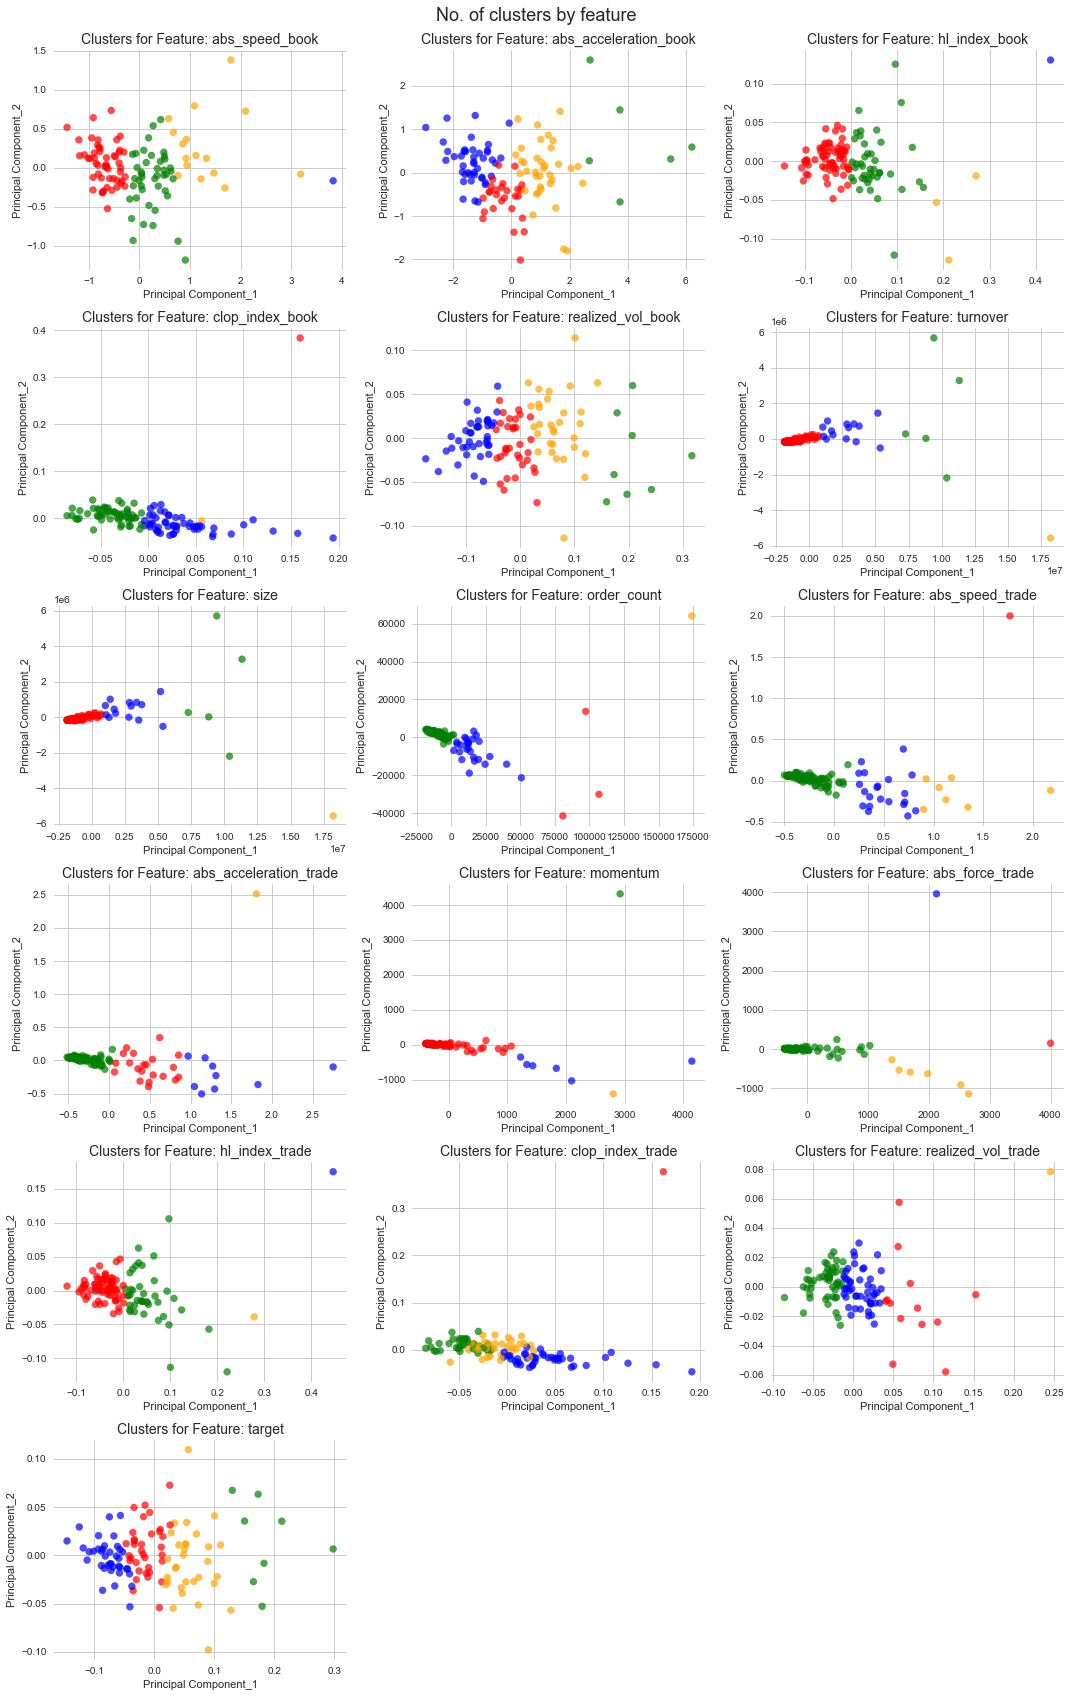

In [521]:
features = [feature for feature in all_features.columns \
            if feature not in ['time_id', 'stock_id']]

plot_clusters(all_features, features, nclusters = 4, ncols=3, figsize=(15,24))

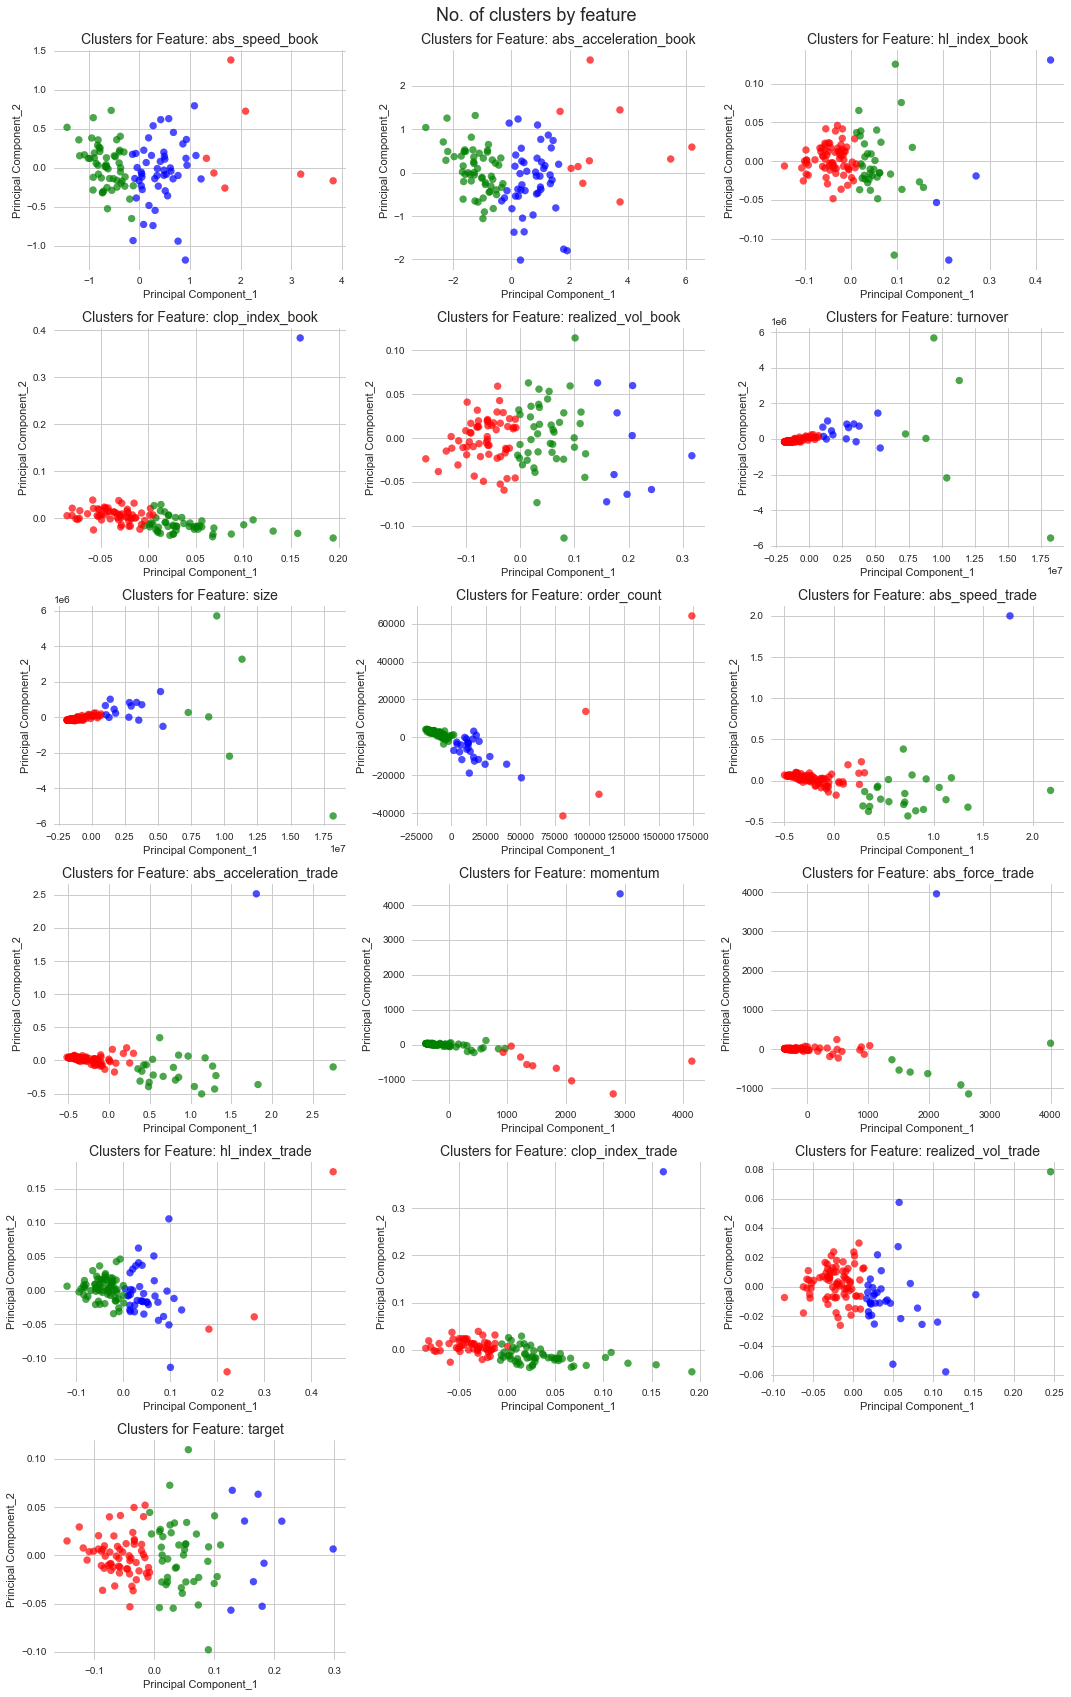

In [523]:
features = [feature for feature in all_features.columns \
            if feature not in ['time_id', 'stock_id']]

plot_clusters(all_features, features, nclusters = 3, ncols=3, figsize=(15,24))

In [454]:
X = s0_features_and_target.drop(['time_id', 'stock_id', 'target'], axis=1).to_numpy()
y = s0_features_and_target['target'].to_numpy()

scale = StandardScaler()
X_scaled = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2451, 7), (613, 7), (2451,), (613,))

In [430]:
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)
y_preds = lr_model.predict(X_test)

R2 = round(r2_score(y_test, y_preds),3)
RMSPE = round(rmspe(y_test, y_preds),3)

print(f'Performance of Linear Regression Model: R2 score: {R2}, RMSPE: {RMSPE}')


Performance of Linear Regression Model: R2 score: 0.642, RMSPE: 0.325


In [455]:
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)
y_preds = lr_model.predict(X_test)

R2 = round(r2_score(y_test, y_preds),3)
RMSPE = round(rmspe(y_test, y_preds),3)

print(f'Performance of Linear Regression Model: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of Linear Regression Model: R2 score: 0.641, RMSPE: 0.327


### Stock_id=100

### 3.0 Train.csv and test.csv files

This file contains the target for each time_id. The **target** is the realized volatility in the 10-min time window following the time_id in question, so it is the value that needs to be predicted based on book and trade data available for a particular time_id.


In [286]:
train_file = pd.read_csv('../Raw_data/train.csv')
train_file.head(10)


stock_id  time_id    target
0         0        5  0.004136
1         0       11  0.001445
2         0       16  0.002168
3         0       31  0.002195
4         0       62  0.001747
5         0       72  0.004912
6         0       97  0.009388
7         0      103  0.004120
8         0      109  0.002182
9         0      123  0.002669

In [216]:
realized_vol = realized_volatility(booktrain_trial['logreturn'])
realized_vol

0.0038217259183637893

In [129]:
list_order_book_file_train = glob.glob('../Raw_data/book_train.parquet/stock_id=*')


for 
df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train,
                                                           prediction_column_name='pred')

train_file = train_file[train_file['stock_id'] == 0]
train_file['row_id'] = train_file['stock_id'].astype(str) + '-' + train_file['time_id'].astype(str)
train_file = train_file[['row_id','target']]
df_joined = train_file.merge(df_past_realized_train[['row_id','pred']], on = ['row_id'], how = 'left')
df_joined.head()


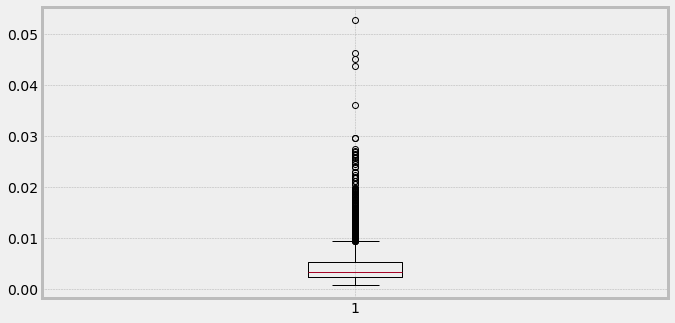

In [151]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.boxplot(df_past_realized_train["pred"])
plt.show()

In [132]:
train_file = pd.read_csv('../Raw_data/train.csv')
test_file = pd.read_csv('../Raw_data/test.csv')
train_file.head(10)

stock_id  time_id    target
0         0        5  0.004136
1         0       11  0.001445
2         0       16  0.002168
3         0       31  0.002195
4         0       62  0.001747
5         0       72  0.004912
6         0       97  0.009388
7         0      103  0.004120
8         0      109  0.002182
9         0      123  0.002669

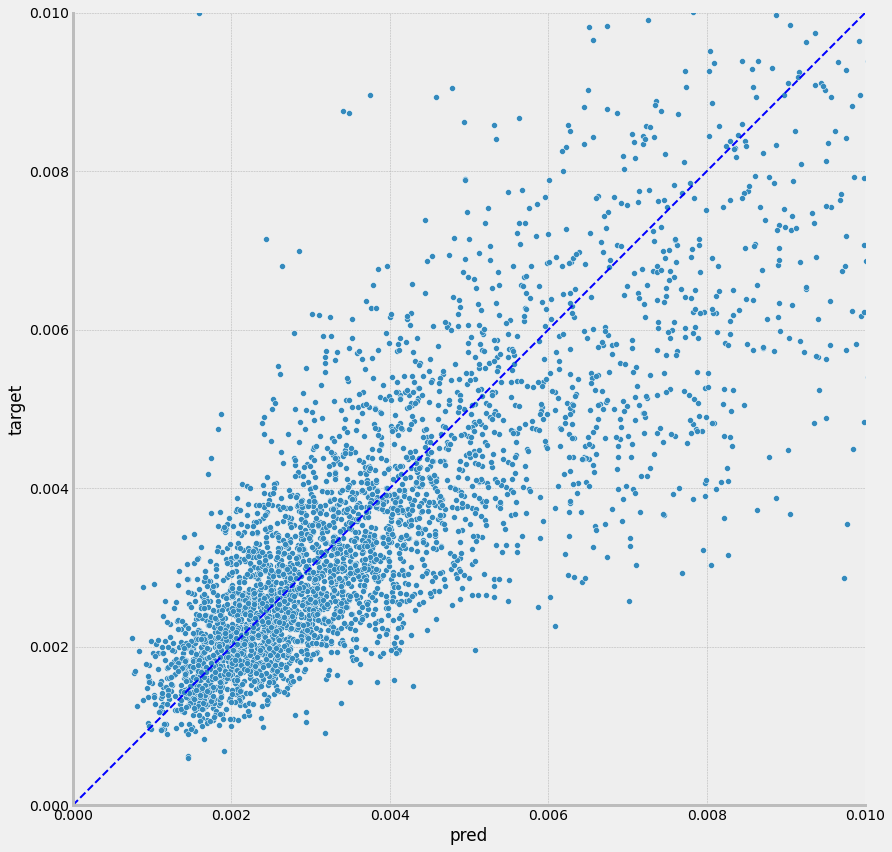

In [307]:
plt.style.use('bmh')
g = sns.relplot(x= 'pred', y = 'target', data = df_joined, kind='scatter')
g.fig.set_size_inches(15,15)
plt.xlim(0.0, 0.01)
plt.ylim(0.0, 0.01)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot([0,0.01], [0,0.01], linestyle = "--", color="blue")
plt.show()


In [163]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

R2 = round(r2_score(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pred']),3)

print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')


Performance of the naive prediction: R2 score: 0.477, RMSPE: 0.393


In [175]:
X = df_joined['pred'].to_numpy().reshape(-1,1)
y = df_joined['target'].to_numpy()

scale = StandardScaler()
X_scaled = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((3064, 1), (766, 1), (3064,), (766,))

In [176]:
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)
y_preds = lr_model.predict(X_test)

R2 = round(r2_score(y_test, y_preds),3)
RMSPE = round(rmspe(y_test, y_preds),3)

print(f'Performance of Linear Regression Model: R2 score: {R2}, RMSPE: {RMSPE}')


Performance of Linear Regression Model: R2 score: 0.697, RMSPE: 0.347


In [177]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_joined['pred'], df_joined['target'], test_size = 0.2, random_state = 123)
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape



((3064,), (766,), (3064,), (766,))

In [179]:
R2 = round(r2_score(y_test2, X_test2),3)
RMSPE = round(rmspe(y_test2, X_test2),3)

print(f'Performance of naive model: R2 score: {R2}, RMSPE: {RMSPE}')


Performance of naive model: R2 score: 0.424, RMSPE: 0.389


In [187]:

volume = pd.DataFrame(trade_train_0.groupby('time_id')[['size', 'order_count']].sum()).reset_index()
volume.head()

time_id  size  order_count
0        5  3179          110
1       11  1289           57
2       16  2161           68
3       31  1962           59
4       62  1791           89

In [188]:
volume.describe()

time_id          size  order_count
count   3830.000000   3830.000000  3830.000000
mean   16038.933681   3212.919843   102.862141
std     9366.261949   2060.851470    52.711362
min        5.000000     64.000000     5.000000
25%     7856.500000   1854.250000    66.000000
50%    15852.500000   2682.000000    91.000000
75%    23988.500000   3941.250000   127.000000
max    32767.000000  20577.000000   498.000000

In [98]:
book_temp = book_train_0[:10000]
trade_temp = trade_train_0[:10000]


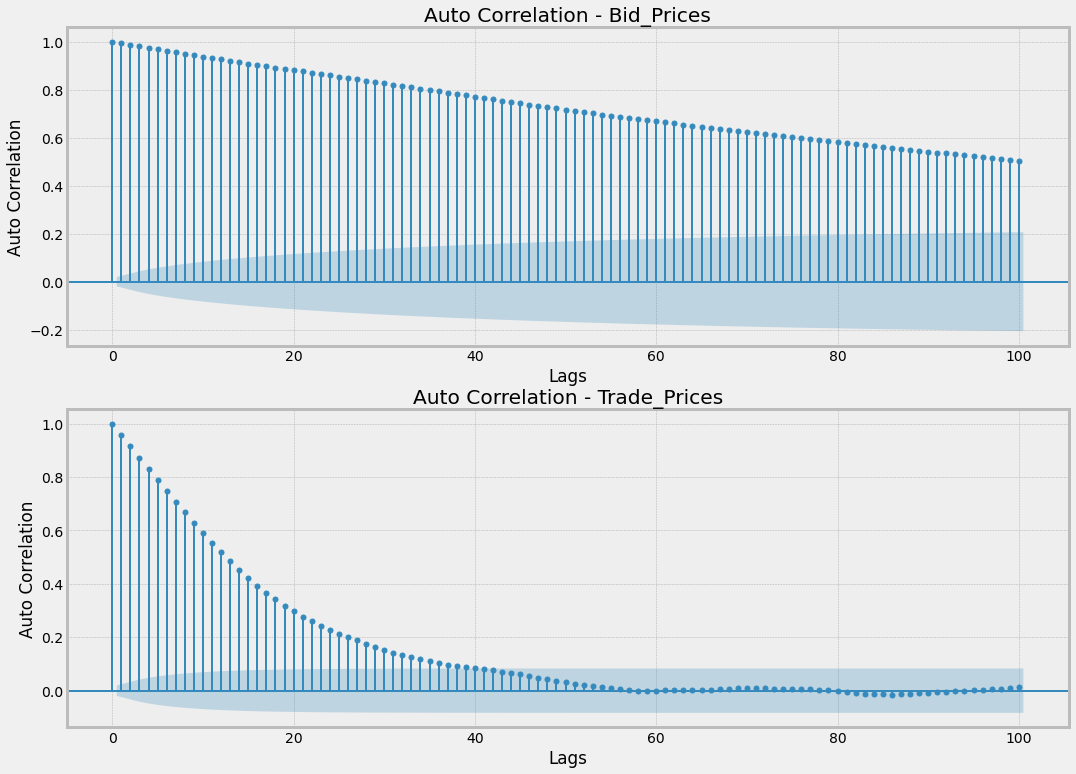

In [99]:

# Plot the acf function for bid and trade prices

fig, ax = plt.subplots(2,1,figsize=(16,12))

plot_acf(book_temp.bid_price1, alpha=0.05, lags = 100, ax = ax[0])
ax[0].set_ylabel('Auto Correlation')
ax[0].set_xlabel('Lags')
ax[0].set_title('Auto Correlation - Bid_Prices')

plot_acf(trade_temp.price, alpha=0.05, lags = 100, ax = ax[1])
ax[1].set_ylabel('Auto Correlation')
ax[1].set_xlabel('Lags')
ax[1].set_title('Auto Correlation - Trade_Prices')

plt.show()


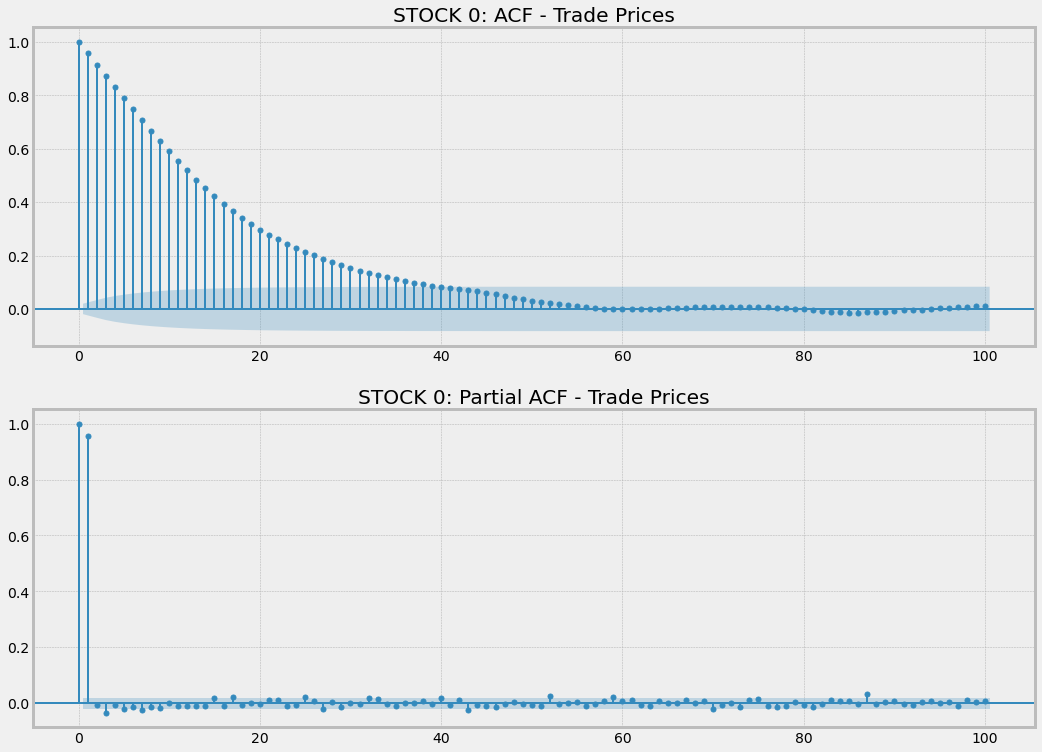

In [100]:
# Plot the acf and pacf function for trade prices

plt.style.use('bmh')
fig, ax = plt.subplots(2,1,figsize=(16,12))

plot_acf(trade_temp.price, alpha=0.05, lags = 100, ax = ax[0])
ax[0].set_title("STOCK 0: ACF - Trade Prices")

plot_pacf(trade_temp.price, alpha=0.05, lags = 100, ax = ax[1])
ax[1].set_title("STOCK 0: Partial ACF - Trade Prices")

plt.show()


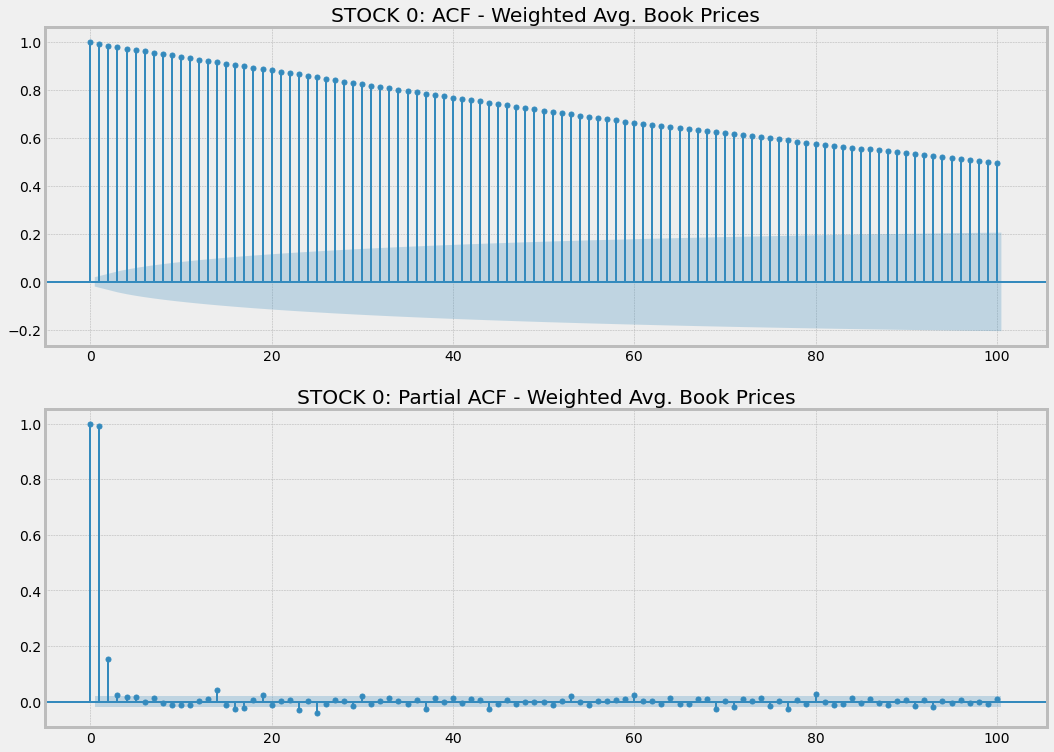

In [101]:

# Plot the acf and pacf function for Weighted Avg. Book Prices

plt.style.use('bmh')
fig, ax = plt.subplots(2,1,figsize=(16,12))

plot_acf(book_temp.wap1, alpha=0.05, lags = 100, ax = ax[0])
ax[0].set_title("STOCK 0: ACF - Weighted Avg. Book Prices")

plot_pacf(book_temp.wap1, alpha=0.05, lags = 100, ax = ax[1])
ax[1].set_title("STOCK 0: Partial ACF - Weighted Avg. Book Prices")

plt.show()

In [102]:
trade_temp['%_returns'] = trade_temp.price.pct_change() * 100.0
trade_temp.head()

C:\Users\amite\AppData\Local\Temp/ipykernel_7252/905397612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_temp['%_returns'] = trade_temp.price.pct_change() * 100.0


time_id  seconds_in_bucket     price  size  order_count  %_returns
0        5                 21  1.002301   326           12        NaN
1        5                 46  1.002778   128            4   0.047565
2        5                 50  1.002818    55            1   0.004029
3        5                 57  1.003155   121            5   0.033593
4        5                 68  1.003646     4            1   0.048900

In [111]:
trade_temp.describe()

time_id  seconds_in_bucket         price         size  \
count  10000.000000       10000.000000  10000.000000  10000.00000   
mean    1280.653000         297.245600      0.999502     96.07690   
std      703.397415         174.253867      0.002849    144.22076   
min        5.000000           0.000000      0.976170      1.00000   
25%      650.000000         144.000000      0.998303      2.00000   
50%     1291.000000         298.000000      0.999780     28.00000   
75%     1890.000000         450.000000      1.000989    121.00000   
max     2447.000000         599.000000      1.014681   2135.00000   

        order_count    %_returns  
count  10000.000000  9999.000000  
mean       3.187200    -0.000022  
std        3.338903     0.083523  
min        1.000000    -1.440150  
25%        1.000000    -0.022915  
50%        2.000000     0.000000  
75%        4.000000     0.021112  
max       70.000000     1.374102

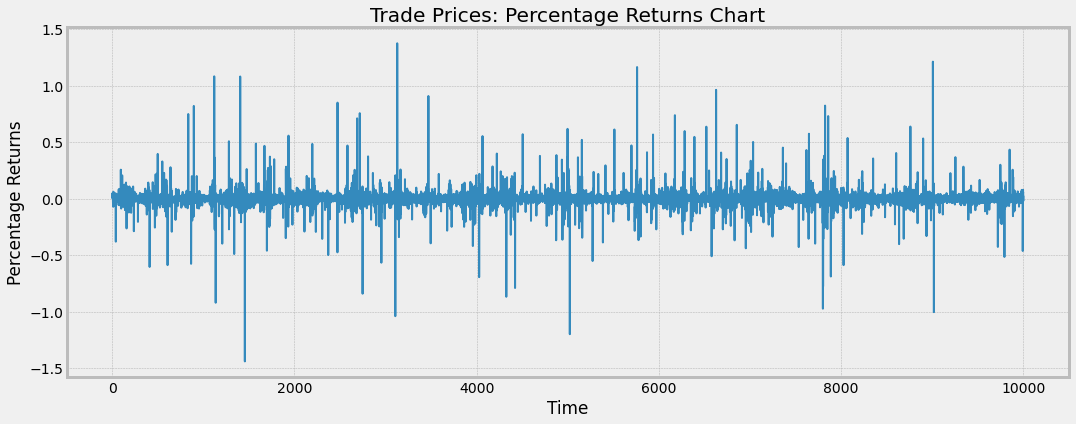

In [104]:
plt.style.use('bmh')
fig, ax = plt.subplots(1,1,figsize=(16,6))

ax.plot(trade_temp[1:].index, trade_temp[1:]['%_returns'])
ax.set_ylabel('Percentage Returns')
ax.set_xlabel('Time')
ax.set_title('Trade Prices: Percentage Returns Chart')
plt.show()


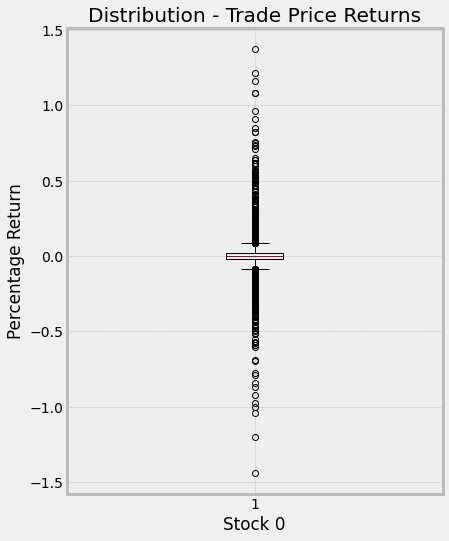

In [112]:
fig, ax = plt.subplots(1,1, figsize = (6,8))

ax.boxplot(trade_temp[1:]['%_returns'])
ax.set_title("Distribution - Trade Price Returns")
ax.set_xlabel("Stock 0")
ax.set_ylabel("Percentage Return")

plt.show()


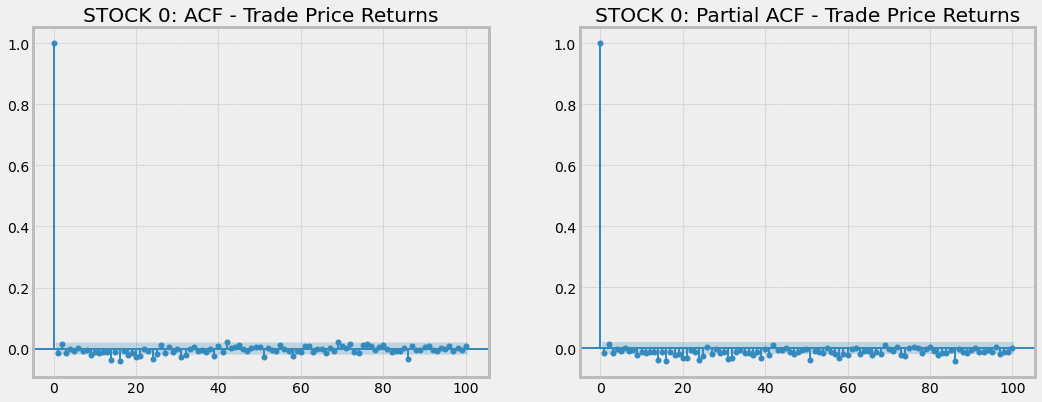

In [110]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

plot_acf(trade_temp[1:]['%_returns'], alpha=0.05, lags = 100, ax = ax[0])
ax[0].set_title("STOCK 0: ACF - Trade Price Returns")

plot_pacf(trade_temp[1:]['%_returns'], alpha=0.05, lags = 100, ax = ax[1])
ax[1].set_title("STOCK 0: Partial ACF - Trade Price Returns")

plt.show()

In [82]:
from statsmodels.tsa.stattools import adfuller

results_price = adfuller(trade_temp[1:].price)
print(f'The p-value of the Augmented Dickey Fuller test on Trade prices is: {results_price[1]:4.4f}')


The p-value of the Augmented Dickey Fuller test on Trade prices is: 0.0000


In [105]:
results_returns = adfuller(trade_temp[1:]['%_returns'])
print(f'The p-value of the Augmented Dickey Fuller test on Trade returns is: {results_returns[1]:4.4f}')


The p-value of the Augmented Dickey Fuller test on Trade returns is: 0.0000


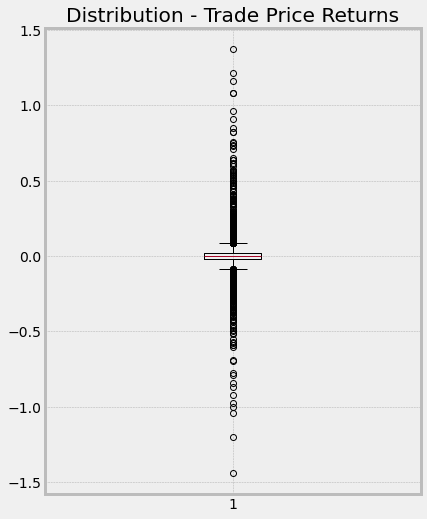

### Stock_id=1

In [51]:
book_train_1 = pd.read_parquet('../Raw_data/book_train.parquet/stock_id=1/31a1c5cd6d8546b383d10373db762236.parquet')
book_train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507532 entries, 0 to 1507531
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   time_id            1507532 non-null  int16  
 1   seconds_in_bucket  1507532 non-null  int16  
 2   bid_price1         1507532 non-null  float32
 3   ask_price1         1507532 non-null  float32
 4   bid_price2         1507532 non-null  float32
 5   ask_price2         1507532 non-null  float32
 6   bid_size1          1507532 non-null  int32  
 7   ask_size1          1507532 non-null  int32  
 8   bid_size2          1507532 non-null  int32  
 9   ask_size2          1507532 non-null  int32  
dtypes: float32(4), int16(2), int32(4)
memory usage: 51.8 MB


In [52]:
book_train_1['wap1'] = (book_train_1.bid_price1*book_train_1.ask_size1 + book_train_1.ask_price1*book_train_1.bid_size1) \
                        /(book_train_1.ask_size1 + book_train_1.bid_size1)
book_train_1.head()

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.000754    1.001542    1.000689    1.001607   
1        5                  1    1.000754    1.001673    1.000689    1.001739   
2        5                  2    1.000754    1.001411    1.000623    1.001476   
3        5                  3    1.000754    1.001542    1.000689    1.001607   
4        5                  4    1.000754    1.001476    1.000623    1.001542   

   bid_size1  ask_size1  bid_size2  ask_size2      wap1  
0          1         25         25        100  1.000785  
1         26         60         25        100  1.001032  
2          1         25         25        125  1.000780  
3        125         25        126         36  1.001411  
4        100        100         25         25  1.001115

In [53]:
trade_train_1 = pd.read_parquet('../Raw_data/trade_train.parquet/stock_id=1/170b39f1f7144bb3b4554aabc336106e.parquet')
trade_train_1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296210 entries, 0 to 296209
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   time_id            296210 non-null  int16  
 1   seconds_in_bucket  296210 non-null  int16  
 2   price              296210 non-null  float32
 3   size               296210 non-null  int32  
 4   order_count        296210 non-null  int16  
dtypes: float32(1), int16(3), int32(1)
memory usage: 4.0 MB


In [67]:
trade_train_1.describe()

time_id  seconds_in_bucket          price           size  \
count  296210.00000      296210.000000  296210.000000  296210.000000   
mean    15964.78176         297.849924       1.000025     162.053800   
std      9405.00168         173.628242       0.004899     280.820086   
min         5.00000           0.000000       0.937487       1.000000   
25%      7743.00000         147.000000       0.998156      15.000000   
50%     15770.00000         297.000000       0.999951     100.000000   
75%     23834.00000         448.000000       1.001696     200.000000   
max     32767.00000         599.000000       1.049819   35727.000000   

         order_count  
count  296210.000000  
mean        3.113541  
std         3.394705  
min         1.000000  
25%         1.000000  
50%         2.000000  
75%         4.000000  
max       129.000000

In [62]:
book_temp = book_train_1[:10000]
trade_temp = trade_train_1[:10000]


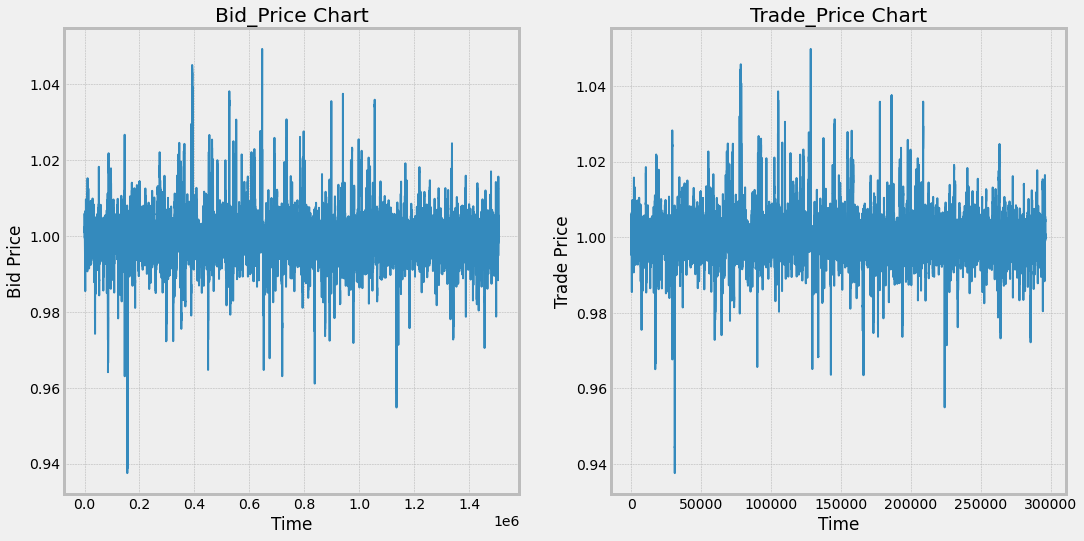

In [55]:
plt.style.use('bmh')
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(book_train_1.index, book_train_1.bid_price1)
ax[0].set_ylabel('Bid Price')
ax[0].set_xlabel('Time')
ax[0].set_title('Bid_Price Chart')

ax[1].plot(trade_train_1.index, trade_train_1.price)
ax[1].set_ylabel('Trade Price')
ax[1].set_xlabel('Time')
ax[1].set_title('Trade_Price Chart')

plt.show()

In [63]:
trade_temp['returns'] = trade_temp.price.pct_change()
trade_temp.head()

C:\Users\amite\AppData\Local\Temp/ipykernel_7252/2556525513.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_temp['returns'] = trade_temp.price.pct_change()


time_id  seconds_in_bucket     price  size  order_count   returns
0        5                 28  1.002080   553           11       NaN
1        5                 39  1.002460     8            3  0.000379
2        5                 42  1.002308   147            4 -0.000152
3        5                 44  1.002788     1            1  0.000479
4        5                 51  1.002657   100            2 -0.000131

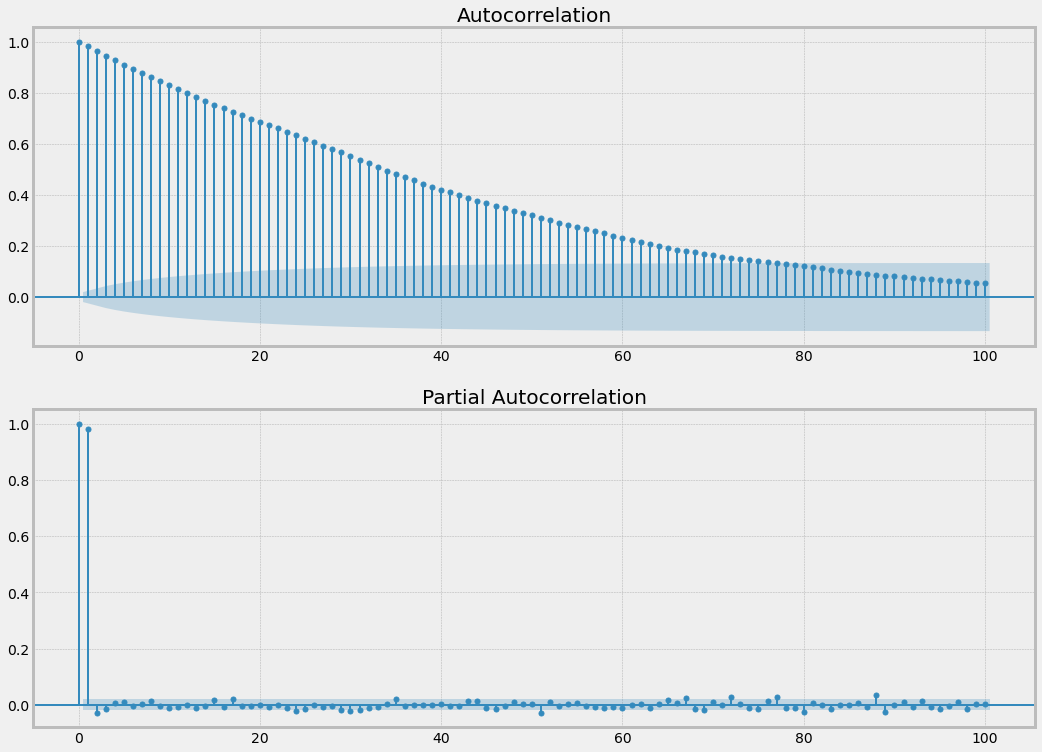

In [64]:
plt.style.use('bmh')
fig, ax = plt.subplots(2,1,figsize=(16,12))

plot_acf(trade_temp.price, alpha=0.05, lags = 100, ax = ax[0])

plot_pacf(trade_temp.price, alpha=0.05, lags = 100, ax = ax[1])

plt.show()

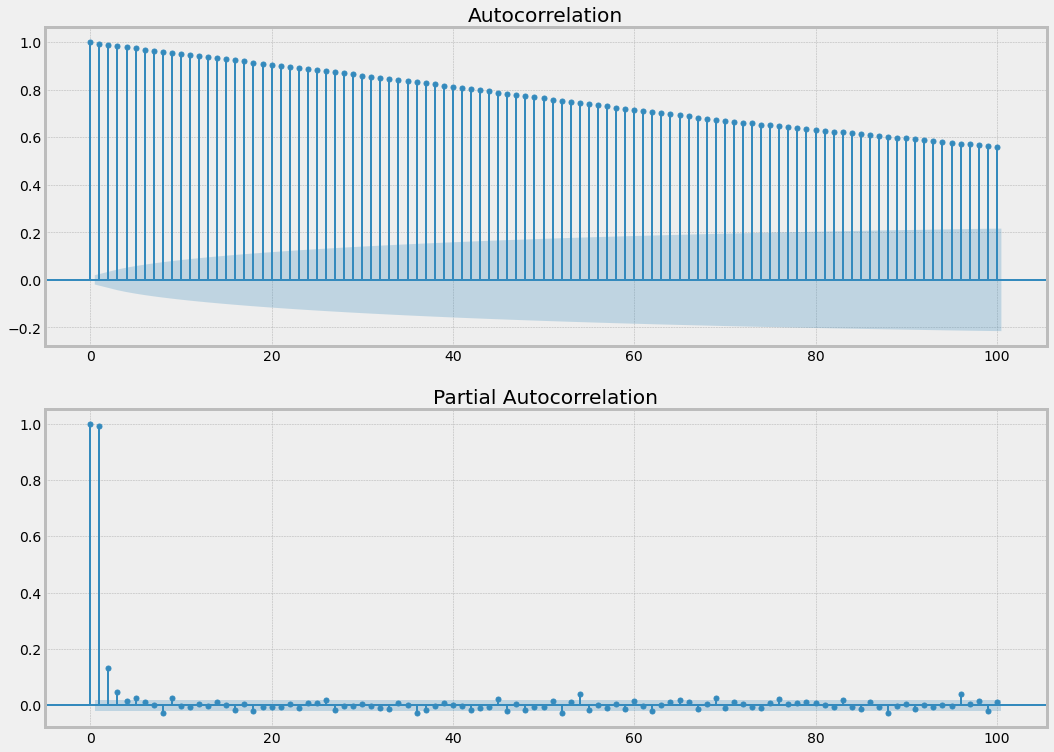

In [65]:
plt.style.use('bmh')
fig, ax = plt.subplots(2,1,figsize=(16,12))

plot_acf(book_temp.wap1, alpha=0.05, lags = 100, ax = ax[0])

plot_pacf(book_temp.wap1, alpha=0.05, lags = 100, ax = ax[1])

plt.show()

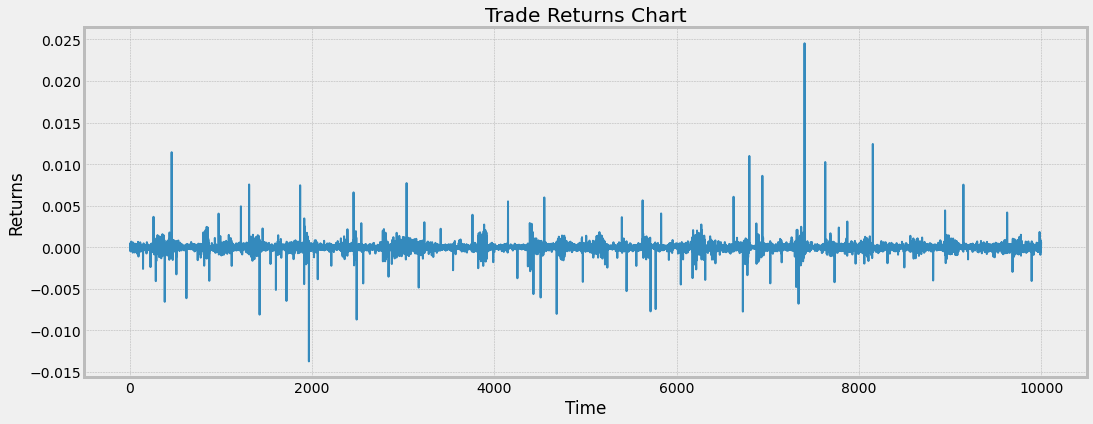

In [66]:
fig, ax = plt.subplots(1,1,figsize=(16,6))

ax.plot(trade_temp[1:].index, trade_temp[1:].returns)
ax.set_ylabel('Returns')
ax.set_xlabel('Time')
ax.set_title('Trade Returns Chart')
plt.show()

In [68]:
from statsmodels.tsa.stattools import adfuller

results_price = adfuller(trade_temp[1:].price)
print(f'The p-value of the test on prices is: {results_price[1]:4.4f}')

results_returns = adfuller(trade_temp[1:].returns)
print(f'The p-value of the test on returns is: {results_returns[1]:4.4f}')


The p-value of the test on prices is: 0.0000
The p-value of the test on returns is: 0.0000


### Stock_id=100

In [69]:
book_train_100 = pd.read_parquet('../Raw_data/book_train.parquet/stock_id=100/9495f2c64cee42078601dee7408e3c36.parquet')
book_train_100['wap1'] = (book_train_100.bid_price1*book_train_100.ask_size1 + book_train_100.ask_price1*book_train_100.bid_size1) \
                        /(book_train_100.ask_size1 + book_train_100.bid_size1)
book_train_100.head()

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    0.999077    1.000103    0.999009    1.000239   
1        5                  4    0.999214    1.000103    0.999145    1.000239   
2        5                  5    0.999282    1.000239    0.999214    1.000376   
3        5                  6    0.999487    1.000786    0.999419    1.000855   
4        5                  7    0.999624    1.000786    0.999556    1.000855   

   bid_size1  ask_size1  bid_size2  ask_size2      wap1  
0        100          7         64        100  1.000035  
1        300          7        310        100  1.000082  
2        700        201        400         36  1.000026  
3        100        101         10         50  1.000134  
4        200        101        100         50  1.000396

In [70]:
trade_train_100 = pd.read_parquet('../Raw_data/trade_train.parquet/stock_id=100/c6b5a2974aac4210a6803c5907baaa07.parquet')


In [92]:
book_temp = book_train_100[:10000]
trade_temp = trade_train_100[:10000]
trade_temp['%_returns'] = trade_temp.price.pct_change() * 100.0
trade_temp.head()


C:\Users\amite\AppData\Local\Temp/ipykernel_7252/4180292391.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_temp['%_returns'] = trade_temp.price.pct_change() * 100.0


time_id  seconds_in_bucket     price  size  order_count  %_returns
0        5                  5  1.000103     7            2        NaN
1        5                  6  1.000239   201            4   0.013685
2        5                  9  1.000444     1            1   0.020504
3        5                 28  1.000376    12            3  -0.006825
4        5                 30  1.000444     3            1   0.006831

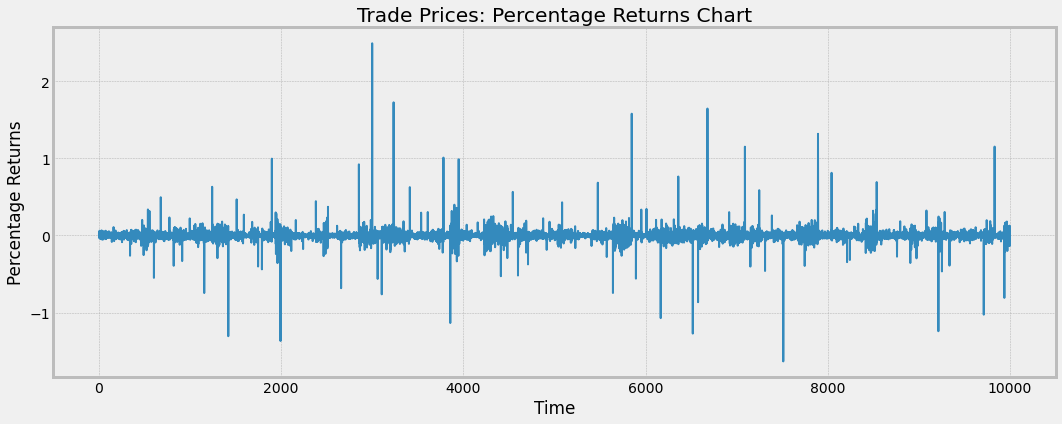

In [97]:
plt.style.use('bmh')
fig, ax = plt.subplots(1,1,figsize=(16,6))

ax.plot(trade_temp[1:].index, trade_temp[1:]['%_returns'])
ax.set_ylabel('Percentage Returns')
ax.set_xlabel('Time')
ax.set_title('Trade Prices: Percentage Returns Chart')
plt.show()

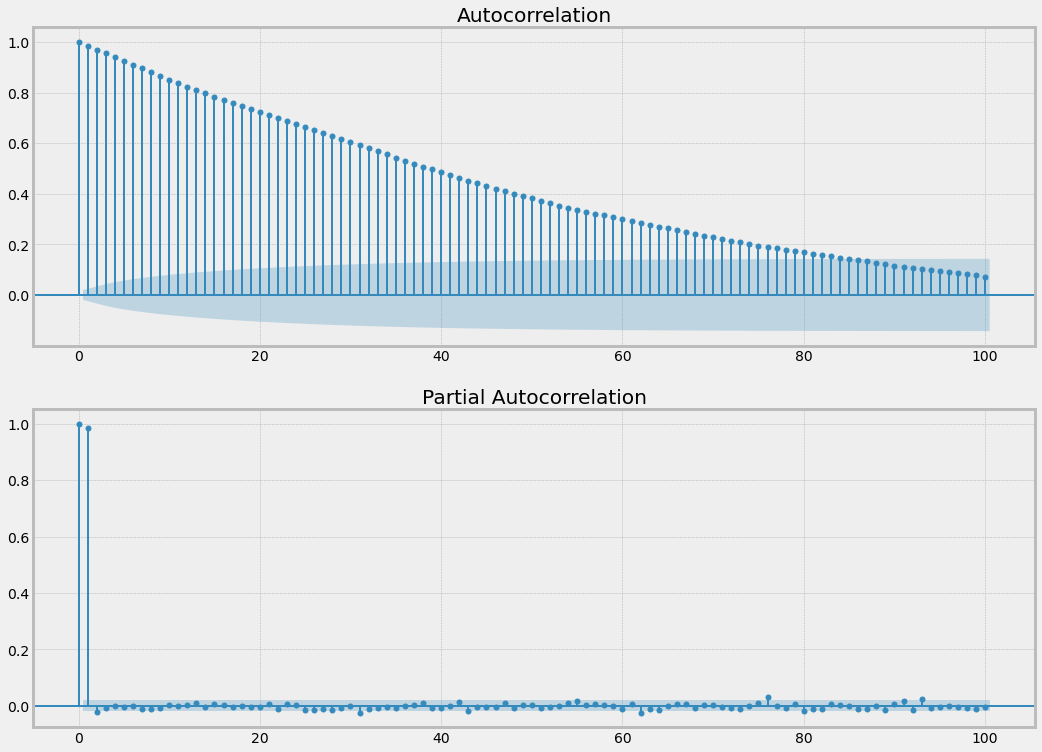

In [74]:
plt.style.use('bmh')
fig, ax = plt.subplots(2,1,figsize=(16,12))

plot_acf(trade_temp.price, alpha=0.05, lags = 100, ax = ax[0])

plot_pacf(trade_temp.price, alpha=0.05, lags = 100, ax = ax[1])

plt.show()

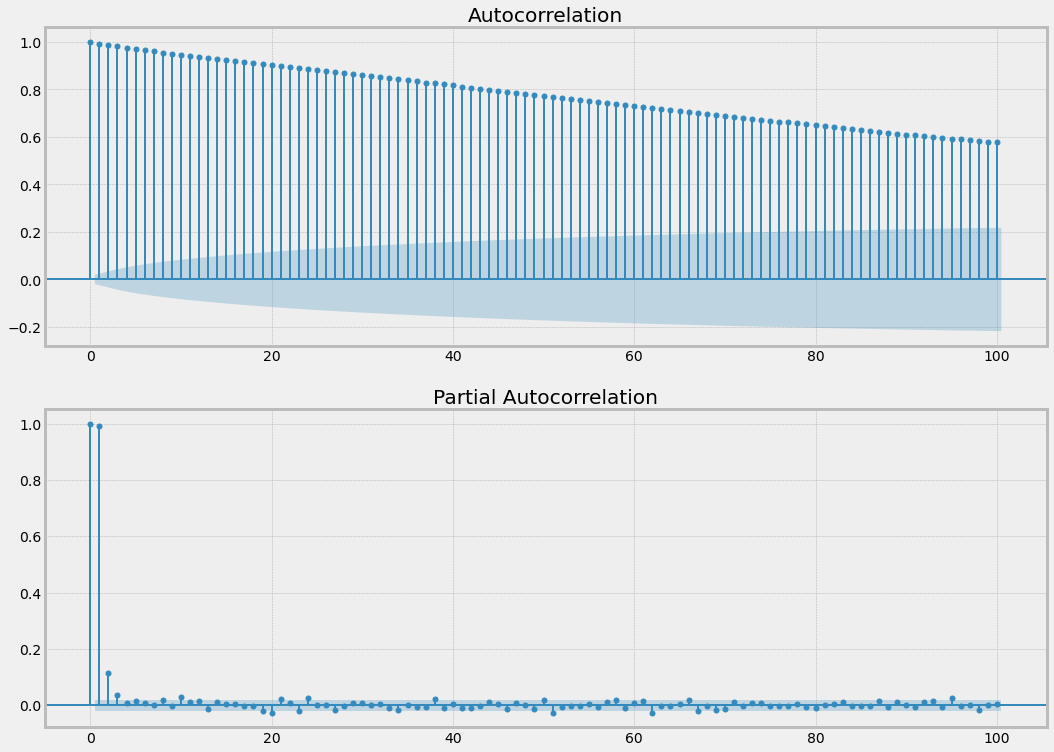

In [75]:
plt.style.use('bmh')
fig, ax = plt.subplots(2,1,figsize=(16,12))

plot_acf(book_temp.wap1, alpha=0.05, lags = 100, ax = ax[0])

plot_pacf(book_temp.wap1, alpha=0.05, lags = 100, ax = ax[1])

plt.show()

In [89]:
x = [100, 101, 102, 105]
y = pd.DataFrame(x, columns = ['Col1'])
y

Col1
0   100
1   101
2   102
3   105

In [90]:
y['returns'] = y.Col1.pct_change()
y

Col1   returns
0   100       NaN
1   101  0.010000
2   102  0.009901
3   105  0.029412